# BigTable MTLM - summative "blob" test
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [1]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math
import pandas

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
generate_student_name()

'KEKO PYDU '

In [3]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }

In [4]:
class BigTable(Layer):

    def __init__(self, _dim, min_w, max_w, **kwargs):
        self.dim = _dim
        self.limits = (min_w, max_w)
        kc =kernel_constraint=WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
#         av_w = (min_w + max_w)/2.0
        initialiser = initializers.RandomUniform(min_w, max_w)  #.RandomUniform(min_w, max_w)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        selector = K.flatten(selector)
        print("flat selector shape", selector.shape)
        print("call kk", self.kernel.shape)
#         selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)
        rows = K.gather(self.kernel, selector)
#         rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [5]:
class Question():
    def __init__(self, qix, min_diff, max_diff, nt, min_active, max_active):
        self.id = qix
        print("Qinit",qix)

#         n_c = nt #randint(min_active, max_active)
#         choices = range(nt) # numpy.random.choice(range(nt), size=n_c, replace=False)
        n_c = randint(min_active, max_active)
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)

        print("Q choices are {}".format(choices))

        not_present= 0 #min_diff
        self.betas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
#             self.betas[c] = random.uniform(min_diff, max_diff)
            self.betas[c]= uniform(min_diff, max_diff) #(1,11)
    def get_magnitude(self):
        comps = [c for c in self.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        return mag
    def get_num_components(self):
        return len([c for c in self.betas if c>0])

    
class Student():
    def __init__(self, ix, min_a, max_a, nt):
        self.id = ix
        self.name = generate_student_name()
        n_c = nt
        choices = range(nt) #numpy.random.choice(range(nt), size=n_c, replace=False)

        not_present= 0 #min_a
        self.thetas = [ not_present for _ in range(nt) ]        

        for c in choices:
            self.thetas[c] = uniform(min_a, max_a) #(7,22)
    def get_magnitude(self):
        comps = [c for c in self.thetas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        return mag
    def get_num_components(self):
        return len([c for c in self.thetas if c>0])
        


In [6]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [7]:
def calculate_pass_probability(thetas, betas):
    p_pass = 1.0
    for th,b in zip(thetas,betas):
#       if th==0:
#           return 0
        p_pass_step=1.0 if (b==0) else (1.0 / (1.0 + exp(-(th-b))))
#       print(th,"vs",b,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
    #print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [8]:
#qs= create_qs(n_qs, minb,maxb, n_traits, min_active_traits, max_active_traits, nnw)
def create_qs(n_qs, beta_min, beta_max, nt, min_active, max_active):
#     random.seed(666)
#     numpy.random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt, min_active, max_active) for qix in range(n_qs)]
    mags = []
    no_comps = []
    for q in master_qs:
        mag = q.get_magnitude()
        nc = q.get_num_components()
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, nc))
        mags.append(mag)
        no_comps.append(nc)
    
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    for q in master_qs:
        print("qid",q.id,q.betas)
  
    return master_qs

In [9]:
def create_students(n_students, theta_min, theta_max, nt):
#     random.seed(666)
#     numpy.random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt) for psix in range(n_students)]
    mags = []
    for psi in psi_list[0:30]:
        mag = psi.get_magnitude()
        nc = psi.get_num_components()
        print("{}, skill={:.2f} across {} comps".format(psi.name, mag, nc))
        mags.append(mag)
    
 ################ PLOTs follow

    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    ax[0].hist(mags)

    if nt >1:
        itemz = array([ s.thetas for s in psi_list ])
    #     fig.set_size_inches(10, 10)
        ax[1].scatter(itemz[:,0], itemz[:,1], alpha=0.2)
        for i, txt in enumerate(itemz):
            ax[1].annotate(i, (itemz[i,0], itemz[i,1]))
        plt.show()
    
    return psi_list
    

In [10]:
from keras.optimizers import Adam
def generate_qs_model(qn_table, psi_table, qn_qmx, psi_qmx, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)    
    psi_row = psi_table(psi_sel)

#     qn_qmx_row = qn_qmx(qn_sel)


#     q_masque = Lambda(lambda q: K.clip(q,0,1))(qn_row)
#     s_masque = Lambda(lambda s: K.clip(s,0,1))(psi_row)


#     q1_s1 = Lambda(lambda qs: qs[0] * qs[1])([q_masque, s_masque])
#     q0 = Lambda(lambda q: 1-q)(q_masque)

#     qn_row= Dropout(0.0)(qn_row)
#     psi_row = Dropout(0.0)(qn_row)
    
    dif = subtract([psi_row, qn_row])
    print("dif",dif.shape)
    Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="sPr_sigmoid")(dif)
#     Prs = multiply([Prs, q1_s1])
#     Prs = add([Prs, q0])

#     Prs = Lambda(lambda ps_q:  ps_q[0]*ps_q[1]*ps_q[2] + (1.0-ps_q[1]) ) ([Prs, q_masque, s_masque])
#     Prs = Lambda(lambda u: K.clip(u,0,1)) (add([Prs, qmx_selector]))
#     Prs = multiply([Prs, qmx_selector])

#     Pr = Lambda(lambda ps: K.exp(K.sum(K.log(ps), axis=1, keepdims=True)), name="sPr_prod")(Prs)
    Pr = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)

    print("Pr",Pr.shape)
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
    return model

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [11]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
    user_patience = 10 #math.inf
    pass_to_remove = True
    
    n_pass = 0
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            qs = [ix for ix in range(len(master_qs))]
            while qs:
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                att = 0
#                 while (not passed) and att<user_patience:
                pp,passed = attempt_q(psi, q)
                if passed:
                    n_pass+=1
                tup = (psi.id, q.id, passed, pp)
                attempt_n_map[(q.id,psi.id)] += 1
                attempts.append(tup)
#                 print("p_pass was",pp,"=",passed) #, "run p:", 1-(1-pp)**max_atts)
                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)
                att += 1
#                 if (not pass_to_remove) or (pass_to_remove and passed):
                qs.remove(qix)
#                 print("len qs is", len(qs))
    gc.collect()
    print(">>Passed {}/{}".format(n_pass, len(attempts)))
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map

In [12]:
def init_weights(master_qs, psi_list, attempts_by_psi, attempts_by_q, q_table, s_table, min_b, max_b, min_th, max_th):
    psi_wgts = s_table.get_weights()[0]
    for s in psi_list:
#         attz = [tup[2] for tup in attempts_by_psi[s.name]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log(p / (1-p))
        psi_wgts[s.id,:] = numpy.random.uniform(min_th,max_th, size=psi_wgts.shape[1])
        print(psi_wgts[s.id,:])
    s_table.set_weights([ psi_wgts ])

    qn_wgts = q_table.get_weights()[0]
    for q in master_qs:
#         attz = [tup[2] for tup in attempts_by_q[q]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log((1-p) / p)
        qn_wgts[q.id,:]= numpy.random.uniform(min_b,max_b, size=qn_wgts.shape[1])
        print(qn_wgts[q.id,:])
    q_table.set_weights([ qn_wgts ])
    

In [13]:
import os
import IPython

def calibrate(master_qs, psi_list, qs_model, attempts, val, attempts_by_psi, attempts_by_q, s_table, q_table, s_qmx_table, q_qmx_table, n_iter=20, record_param_fit=False):
    es = EarlyStopping(monitor="val_loss", mode="auto", patience=0)
#     random.seed(666)
    min_mse = 1000
    min_avg_fit_rmse = math.inf
    min_loss= math.inf
    q_outer_mses = []
    q_outer_accs = []
    s_outer_mses = []
    s_outer_accs = []
    th_mses = []
    b_mses = []
    th_accs= []
    b_accs =[]
    h= []
    avg_fit_rmses = []
    th_fit_rmses = []
    b_fit_rmses = []
    init_patience = 100
    patience = init_patience

    shuffle(attempts)

    qices = array([int(tup[1]) for tup in attempts]).flatten() #reshape(-1,1)
    psices = array([int(tup[0]) for tup in attempts]).flatten() #reshape(-1,1)
    pfs = array([tup[3] for tup in attempts]).flatten() #reshape(-1,1)
    len_all = qices.shape[0]
    
    split = len_all//10
    
#     vqices = qices[0:split] #array([int(tup[1]) for tup in val]).flatten() #reshape(-1,1)
#     vpsices = psices[0:split] #array([int(tup[0]) for tup in val]).flatten() #reshape(-1,1)
#     #vpfs = pfs[0:split] #array([tup[2] for tup in val]).flatten() #reshape(-1,1)
#     vpfs = array([tup[3] for tup in attempts]).flatten()[0:split] #array([tup[2] for tup in val]).flatten() #reshape(-1,1)

    vqices = qices
    vpsices = psices
    vpfs = pfs

#     qz = qices[split:]
#     sz = psices[split:]
#     pfz = pfs[split:]
    qz = qices
    sz = psices
    pfz = pfs
    
    print(qz)
    print(sz)
    print(pfz)
#     input("Xsan")
    
    loss = False
    mse = False
    acc = False
    early_stop = True
    min_stop = 0
#     n_iter = 1

    real_thetas = numpy.sort(array([s.thetas for s in psi_list]))
    real_betas = numpy.sort(array([q.betas for q in master_qs]))

#     n_iter=1
    for i in range(n_iter):
        base_ix = 0
        done = False
#         for j in range(chunkz+1):
        j = 0
        sub_h = []
        
#         predz = qs_model.predict(x=[qz, sz], verbose=0)
#         print("~~~~ ~ ~ ~~~")
#         for ix,(pred,q,s,p) in enumerate(zip(predz,qz,sz,pfz)):
#             print(q,s,p,"-?",pred)
#             if ix>10:
#                 break
        
        qs_model.train_on_batch(x=[qz, sz], y=pfz)#, epochs=10, shuffle=True, batch_size=1, callbacks=[es])
#         qs_model.fit(x=[qz,sz],y=pfz, epochs=1000, validation_split=0.10, batch_size=32, callbacks=[es])
#         qs_model.fit(x=[qz,sz],y=pfz, epochs=1, batch_size=len(pfz), shuffle=True)
      
        if i % 10 == 0:
            loss, mse, acc = qs_model.evaluate(x=[vqices, vpsices], y=vpfs, verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
            sub_h.append((loss,mse,acc))
            print("i =",i)

#             av_rmse = (th_rmse/len(psi_list) +b_rmse/len(master_qs))
#             av_rmse = acc #(th_rmse+b_rmse)/2.0
#             av_rmse = b_rmse
            pred_thetas = numpy.sort(s_table.get_weights()[0])
#             if i>0 and i%100 ==0:
#                 noize = numpy.random.uniform(0.99,1.01, size=pred_thetas.shape)
#                 s_table.set_weights([ pred_thetas*noize, ])
                        
            diffz = numpy.abs(pred_thetas - real_thetas)
            differr = numpy.sum(diffz)/len(psi_list*real_thetas.shape[1])
            th_err = differr
            print("th",differr)

            pred_betas = numpy.sort(q_table.get_weights()[0])

#             if i>0 and i%100 ==0:
#                 noize = numpy.random.uniform(0.99,1.01, size=pred_betas.shape)
#                 q_table.set_weights([ pred_betas*noize, ])

            diffz = numpy.abs(pred_betas - real_betas)
            differr = numpy.sum(diffz)/len(master_qs*real_betas.shape[1])
            print("b",differr)

            real_deltas = numpy.repeat(real_thetas, len(real_betas), axis=0) - numpy.repeat(real_betas, len(real_thetas), axis=0)
            pred_deltas = numpy.repeat(pred_thetas, len(pred_betas), axis=0) - numpy.repeat(pred_betas, len(pred_thetas), axis=0)
            delta_deltas = numpy.abs(pred_deltas - real_deltas)
            print(numpy.sum(delta_deltas)/delta_deltas.shape[0])
            
#             print(pred_thetas[0:10])
#             print(real_thetas[0:10])

            av_rmse = (th_err + differr)/2 #numpy.sum(delta_deltas)/delta_deltas.shape[0] #(differr + th_err)/2
            print(av_rmse,mse,acc)
            sub_h = numpy.array(sub_h)
            sub_tup = (sub_h[-1,0],sub_h[-1,1],sub_h[-1,2])
            h.append(sub_tup)

            print("loss =",av_rmse)
            if av_rmse <= min_avg_fit_rmse:
                patience = init_patience
                print("patience reset to", init_patience)
                min_avg_fit_rmse = av_rmse
                min_loss = loss
#                 qs_model.save_weights("qs_best_weights_summative.hdf5")
            else:
                if early_stop and i>min_stop:
#                 if loss < min_loss:
#                     print(loss,"<",min_loss)
                    if patience >0:
                        patience -= 1
                        print("patience now", patience)
                    else:
                        print("Earlying stoppin' @",i)
                        break
                    
    #     del h
    #     loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs)

    #     print(loss, mse, acc)
    return h, min_loss


In [14]:
def calc_arr_arr_err(real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None

    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_cos_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    #print("mae is ",mse)
                    if err < curr_err:
    #                     print("best match", cix, rix)
    #                     print(real_col)
    #                     print(pred_col)
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
    #         print("---")
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        cos_dis = cosine(out_col_arr.flatten(), real_wgts.flatten())
        mean_ll = numpy.mean( out_col_arr - real_wgts )
#         if total_err < min_total_err:
        if cos_dis < best_cos_dis:
            min_total_err = total_err
            best_ll = mean_ll
            chosen = out_col_arr
            best_cos_dis = cos_dis
#             print("new total min mae:", min_total_err)
#             print("new best ll", best_ll)
    return chosen, min_total_err, mean_ll, best_cos_dis

In [15]:
def calc_avg_MAE(qs,ss,sws,qws):
    s_wgtz = array([ s.thetas for s in ss ])
    shat_wgtz = sws
    shat, smin_total_err, mean_ll, cos_dis = calc_arr_arr_err(s_wgtz, shat_wgtz, max_iter=10)

    real_wgtz = array([ q.betas for q in qs ])
    pred_wgtz = qws
    chosen, qmin_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

    return (smin_total_err, qmin_total_err)

In [16]:
def results_sheet(qs,ss,thetas, betas):
    base = 2
    summa=0
    tp,fp,tn,fn=0,0,0,0
    x = []
    summa = 0
    rows = []
    for _ in range(1):
        xa, _, _, _ = generate_attempts(qs,ss)
        x.extend(xa)
        
    N = len(x)
    
    ix=0    
    for tup in x:
        (psi_id, q_id, passed, passed) = tup
        p = calculate_pass_probability(ss[psi_id].thetas, qs[q_id].betas)
        summa += log((p if passed else (1-p)), base)

        pp = uniform(0,1)
        if pp <= p:
            ppassed=1
            if passed:
                tp+=1
            else:
                fp+=1
        else:
            ppassed=0
            if passed:
                fn+=1
            else:
                tn+=1

        row = [psi_id, q_id, passed, ppassed, None, p, None, None, None, None]
        rows.append(row)
    #     print(ix)
        ix += 1

    ix=0
    for tup in x:
        (psi_id, q_id, passed, p) = tup
        phat = calculate_pass_probability(thetas[psi_id], betas[q_id])
#         row = [psi_id, q_id, passed, None, None, p, phat, None, None, None]
#         LR_rows.append([psi_id, q_id] + list(thetas[psi_id]) + list(betas[q_id]) + [phat, passed] )
        summa += log((phat if passed else (1-phat)), base)

        pp = uniform(0,1)
        if pp <= phat:
            ppassed= 1
            if passed:
                tp+=1
            else:
                fp+=1
        else:
            ppassed = 0
            if passed:
                fn+=1
            else:
                tn+=1
    #     df.iloc[ix,4]=ppassed
    #     df.iloc[ix,6]=p
        rows[ix][4] = ppassed
        rows[ix][6] = phat
        p = rows[ix][5]
        residual =  ppassed-p
    #     print("residual is {}-{}:{}".format(ppassed,p,residual))
        std_residual = residual**2 / (p*(1-p))
    #     print("res^2/V=",std_residual)
        rows[ix][7]=residual
        rows[ix][8]=(p*(1-p))
        rows[ix][9]=std_residual
        ix+=1
    rows.append(row)
    

    idx=["s_id","q_id","run0","rerun","mined","p0","p_mined", "residual", "W", "std.resid^2"]
    df = pandas.DataFrame(data=rows, columns=idx)

    MSR = numpy.mean(df["std.resid^2"])
    print("Outfit=",MSR)

    ct=0
    in_tol_ct=0
    out_in_tol_ct=0
    over1_2=0
    out_over1_2=0
    exxx=0
    inxxx=0
    infits = []
    outfits = []
    for q_id in [q.id for q in qs]:
        q_df = df[df["q_id"]==q_id]
        infit = numpy.sum(q_df["std.resid^2"]*q_df["W"])/numpy.sum(q_df["W"])
        outfit = numpy.mean(q_df["std.resid^2"])
        infits.append(infit)
        outfits.append(outfit)
        print("Infit=",infit,"for",q_id)
        print("Outfit=",outfit)
        if infit<1.1:
            in_tol_ct+=1
        elif infit >1.2 and infit < 1.3:
            over1_2+=1
        elif infit >= 1.3:
            inxxx +=1

        if outfit<1.1:
            out_in_tol_ct+=1
        elif outfit >1.2 and outfit < 1.3:
            out_over1_2+=1
        elif outfit >= 1.3:
            exxx +=1
        ct+=1

    infits = array(infits)
    low = numpy.sum(infits<1.1)
    med = numpy.sum((infits>=1.1) & (infits<1.2))
    hi  = numpy.sum((infits>=1.2) & (infits<1.5))
    out = numpy.sum(infits>=1.5)
    print("infit {} ({} {} {} {})".format(numpy.mean(infits),low,med,hi,out))
    # print("infits in tolerance:", in_tol_ct, "/", (ct-in_tol_ct-over1_2), "({},{})".format(over1_2, inxxx))
    outfits = array(outfits)
    print("avg outfit = ", numpy.mean(outfits))
    # print("Outfits in tolerance:", out_in_tol_ct, "/", (ct-out_in_tol_ct-out_over1_2), "({},{})".format(out_over1_2, exxx))
    low = numpy.sum(outfits<1.1)
    med = numpy.sum((outfits>=1.1) & (outfits<1.2))
    hi  = numpy.sum((outfits>=1.2) & (outfits<1.5))
    out = numpy.sum(outfits>=1.5)
    print("outfit {} ({} {} {} {})".format(numpy.mean(outfits), low,med,hi,out))    

    origMSE = numpy.mean((df["run0"] - df["p0"])**2)
    print("origMSE",origMSE)
    embedMSE = numpy.mean((df["run0"] - df["p_mined"])**2)
    print("embedMSE",embedMSE)

    df.to_csv("mltm.{}_{}_{}.df.csv".format(n_traits, min_active_traits, max_active_traits))
    acc = (tp+tn)/len(x)
    print("embed acc:",acc)
    print(tp,fp)
    print(fn,tn)

    ppx = pow( base, (-summa/N))
    print("perplexity is {}".format(ppx))
    print((fn + fp + abs(tp-tn)),":", tp,tn,fp,fn)
    return df

Instructions for updating:
Colocations handled automatically by placer.
Qinit 0
Q choices are [83]
Qinit 1
Q choices are [60 93]
Qinit 2
Q choices are [74 84 37]
Qinit 3
Q choices are [33]
Qinit 4
Q choices are [21  5 69 66 46]
Qinit 5
Q choices are [55 94]
Qinit 6
Q choices are [92 38]
Qinit 7
Q choices are [75 78 74 37]
Qinit 8
Q choices are [20 71 62 14]
Qinit 9
Q choices are [16 61]
Q:0, difficulty=7.10 across 1 components
Q:1, difficulty=11.15 across 2 components
Q:2, difficulty=4.75 across 3 components
Q:3, difficulty=3.41 across 1 components
Q:4, difficulty=15.68 across 5 components
Q:5, difficulty=7.32 across 2 components
Q:6, difficulty=6.78 across 2 components
Q:7, difficulty=13.87 across 4 components
Q:8, difficulty=11.93 across 4 components
Q:9, difficulty=10.20 across 2 components


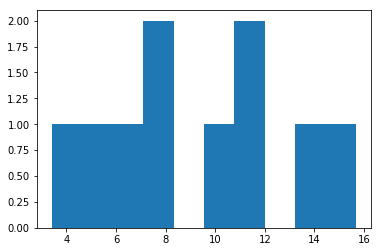

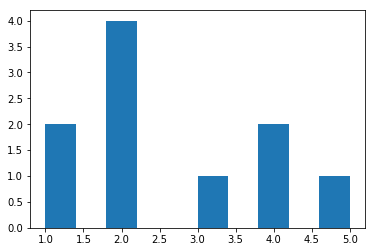

qid 0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7.104402274902175, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
qid 1 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.637173254152449, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7.044680801929538, 0, 0, 0, 0, 0, 0]
qid 2 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.5324828043780947, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.8900118779185413, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.3201090044398265, 0, 0, 0, 0, 0, 0, 0, 0, 0

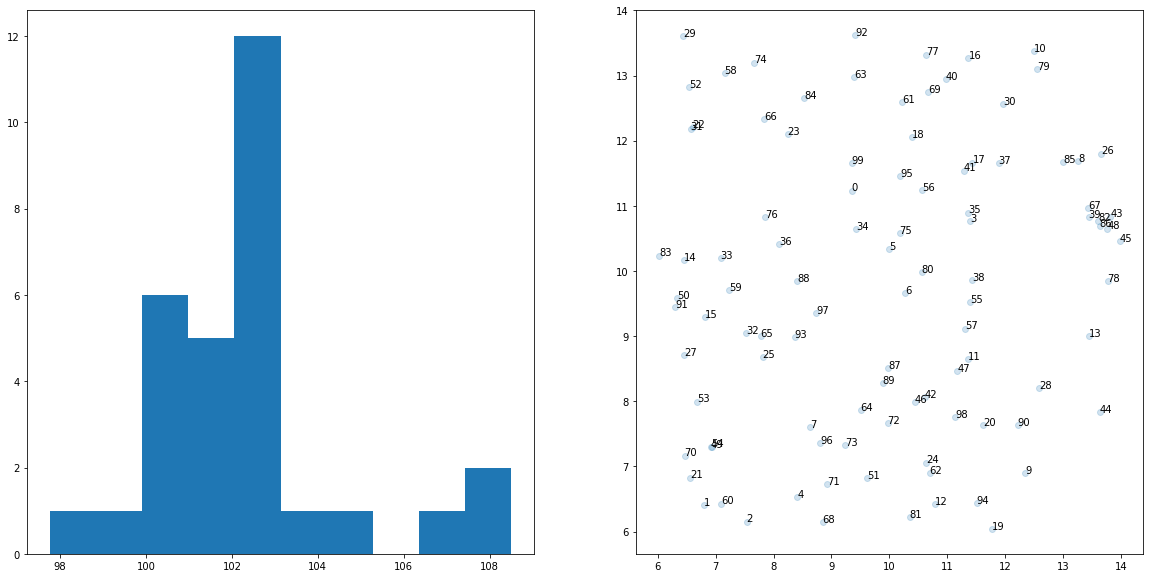

----0

>>Passed 709/1000
----0

>>Passed 707/1000


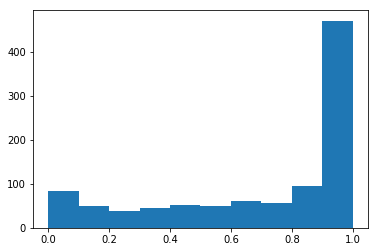

<__main__.BigTable object at 0x7fbef00d59e8> <__main__.BigTable object at 0x7fbee7e43128> Tensor("psi_select:0", shape=(?, 1), dtype=int32) Tensor("q_select:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
kk (10, 100)
selector shape (?, 1)
flat selector shape (?,)
call kk (10, 100)
'rows' shape, (?, 100)
kk (100, 100)
selector shape (?, 1)
flat selector shape (?,)
call kk (100, 100)
'rows' shape, (?, 100)
dif (?, 100)
Pr (?, 1)
[  9.7023468    9.23959064   9.06601715   8.46637154   6.65578794
  10.18596363   9.28395176  10.44133663   6.82697487   9.66254425
  13.8431654   10.07811451  12.60151768  13.41133785   9.33552361
   6.93313265  10.38549328   9.58168411   8.50130081  10.07799816
   9.73785114  13.87938404  12.30729198   7.73266459   9.84022045
  13.41191387   7.37298822  12.96064758  10.49293423  12.70821953
  12.93906212  13.79882812   8.77734756   8.9373827   13.15281582
   6.89554501   8.38764      6.65745926  10.25481224   8.26104927
   7.85041046   7.46969509   6.95675

[  6.77129984  12.71655846  13.06200218  13.99962997   7.45163679
   8.47257042   6.74403763   7.15663242  12.65012646  11.96387482
   6.18181896  11.56832409   9.63232422  10.99100494  11.54968262
   8.02048016  10.7247324   12.66269302  13.6980381   13.46519756
  11.65036106   7.41832781  11.2171936    8.32600212   6.63096476
   6.55950975  13.48011875  10.13283253   7.76217127  13.73249149
  11.21376419   8.29018497   7.79759789  10.17036152  13.25226402
  12.36166191   8.54352379  12.0651226   13.1985321   12.73283291
  12.14059067  12.28589058   7.41398144  13.46408939   7.72193718
  13.79417229   7.84551573  13.05250454   6.6259594    6.71459579
  12.68614674   7.40404224   8.24423313  11.91052055   8.15730667
  12.94796181   7.77129269  10.25099468   6.34100389  11.20118618
   8.58696842   9.19353008  10.74483395   8.36553288   6.45620823
   7.16359663  13.40444088   8.50821018   7.24623775  12.71304035
  10.91283131  13.89373779   8.65267849   9.26555347  13.23773479
   8.62884

[ 8.59246254  3.49909353  8.7422266   9.42645741  8.06886005  4.24037027
  3.39088154  4.02312517  5.08752346  2.46138906  2.230721    7.91997528
  1.80478132  4.38206148  2.392519    2.32117152  1.79333353  1.16953146
  4.67026186  1.36669815  8.00632095  5.39062166  6.8075819   6.87763309
  1.60109437  6.03008986  5.17392159  4.07027721  5.97403193  9.60356903
  2.49246502  1.4402895   5.63372803  1.58734488  1.61859751  2.94215393
  8.43984127  6.20387363  1.93431878  4.48576212  8.7754755   5.73714781
  4.33668566  6.77475357  7.9254365   7.21435547  1.00467741  1.20050955
  5.56299114  6.64866257  4.19027233  3.18636942  6.34000397  1.95768011
  3.35899687  5.20140743  3.48751187  3.40471458  4.99005604  9.35205555
  7.79327679  2.36871362  7.67183447  6.20123816  6.52558136  5.66920376
  4.47601366  4.81845236  1.65322208  8.14130402  5.20715809  3.02668786
  3.72180796  1.33106375  4.55884409  6.55556202  9.29492188  8.27641106
  1.27644205  8.76687622  5.39980888  9.83064556  8

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
i = 0
th 0.367382703011
b 5.1583404302
513.691718584
2.76286156661 0.611826161146 0.0
loss = 2.76286156661
patience reset to 100
i = 10
th 0.747109352503
b 4.26012902755
365.325234735
2.50361919003 0.598968520403 0.0
loss = 2.50361919003
patience reset to 100
i = 20
th 1.38882959797
b 3.43725483546
270.219796492
2.41304221671 0.343488893509 0.0
loss = 2.41304221671
patience reset to 100
i = 30
th 1.76867462755
b 2.99259112999
243.497906621
2.38063287877 0.115733595371 0.0
loss = 2.38063287877
patience reset to 100
i = 40
th 1.91961415368
b 2.81754385048
237.367337839
2.36857900208 0.0812805461884 0.0
loss = 2.36857900208
patience reset to 100
i = 50
th 1.94377410896
b 2.77461984192
236.339761939
2.35919697544 0.0610592469573 0.0
loss = 2.35919697544
patience reset to 100
i = 60
th 1.91151709021
b 2.77860618751
236.10189864

i = 590
th 2.27565586431
b 2.03843910479
242.1423476
2.15704748455 0.000104546171729 0.0
loss = 2.15704748455
patience reset to 100
i = 600
th 2.27934116094
b 2.03392173927
242.404284939
2.1566314501 9.99322996067e-05 0.0
loss = 2.1566314501
patience reset to 100
i = 610
th 2.28292291042
b 2.02951455888
242.662156388
2.15621873465 9.5554159343e-05 0.0
loss = 2.15621873465
patience reset to 100
i = 620
th 2.28629861571
b 2.02517633427
242.909385171
2.15573747499 9.14246196335e-05 0.0
loss = 2.15573747499
patience reset to 100
i = 630
th 2.28944089441
b 2.02088739703
243.134115507
2.15516414572 8.73607081885e-05 0.0
loss = 2.15516414572
patience reset to 100
i = 640
th 2.292673826
b 2.01663080819
243.37131881
2.15465231709 8.37379019358e-05 0.0
loss = 2.15465231709
patience reset to 100
i = 650
th 2.29601571429
b 2.01240134495
243.625237859
2.15420852962 8.0266081728e-05 0.0
loss = 2.15420852962
patience reset to 100
i = 660
th 2.29913946488
b 2.00825281435
243.861789598
2.15369613962 7.

i = 1220
th 2.43588730521
b 1.85426697768
254.644731733
2.14507714145 1.58741722698e-05 0.0
loss = 2.14507714145
patience reset to 100
i = 1230
th 2.43773297443
b 1.85234977816
254.798456737
2.14504137629 1.55818977219e-05 0.0
loss = 2.14504137629
patience reset to 100
i = 1240
th 2.43967637114
b 1.85044286733
254.962972019
2.14505961924 1.52802954544e-05 0.0
loss = 2.14505961924
patience now 99
i = 1250
th 2.44158861561
b 1.84854432769
255.126030744
2.14506647165 1.4990562915e-05 0.0
loss = 2.14506647165
patience now 98
i = 1260
th 2.44346147799
b 1.84666069217
255.2871105
2.14506108508 1.47065092387e-05 0.0
loss = 2.14506108508
patience now 97
i = 1270
th 2.44532313204
b 1.84479565632
255.448730529
2.14505939418 1.44381712016e-05 0.0
loss = 2.14505939418
patience now 96
i = 1280
th 2.44717349796
b 1.84294738222
255.609860677
2.14506044009 1.41717556035e-05 0.0
loss = 2.14506044009
patience now 95
i = 1290
th 2.44899740367
b 1.84111143074
255.769840287
2.1450544172 1.39140623432e-05 0

i = 1870
th 2.53631323862
b 1.75270201204
263.550238155
2.14450762533 5.91215435634e-06 0.0
loss = 2.14450762533
patience now 75
i = 1880
th 2.53756021104
b 1.75140058365
263.661169301
2.14448039734 5.84587872072e-06 0.0
loss = 2.14448039734
patience now 74
i = 1890
th 2.53880411825
b 1.7501010747
263.771965245
2.14445259648 5.78140989091e-06 0.0
loss = 2.14445259648
patience reset to 100
i = 1900
th 2.54007292127
b 1.74880249135
263.886248847
2.14443770631 5.71756860518e-06 0.0
loss = 2.14443770631
patience reset to 100
i = 1910
th 2.54135269375
b 1.74750623042
264.002353248
2.14442946208 5.65145804285e-06 0.0
loss = 2.14442946208
patience reset to 100
i = 1920
th 2.54261605425
b 1.7462179072
264.117128691
2.14441698073 5.58692931736e-06 0.0
loss = 2.14441698073
patience reset to 100
i = 1930
th 2.54386180176
b 1.74493915963
264.22950781
2.1444004807 5.52862715267e-06 0.0
loss = 2.1444004807
patience reset to 100
i = 1940
th 2.54510459623
b 1.74366830568
264.341636199
2.14438645096 5.

i = 2500
th 2.60960049198
b 1.67794187247
270.528393534
2.14377118223 3.24515663124e-06 0.0
loss = 2.14377118223
patience reset to 100
i = 2510
th 2.61063313378
b 1.67683513994
270.631640167
2.14373413686 3.20496734821e-06 0.0
loss = 2.14373413686
patience reset to 100
i = 2520
th 2.61166893009
b 1.67573023782
270.735259914
2.14369958395 3.17556765003e-06 0.0
loss = 2.14369958395
patience reset to 100
i = 2530
th 2.6126947255
b 1.67463047114
270.837567714
2.14366259832 3.14759561479e-06 0.0
loss = 2.14366259832
patience reset to 100
i = 2540
th 2.61371585854
b 1.67353457227
270.939412397
2.14362521541 3.12382155971e-06 0.0
loss = 2.14362521541
patience reset to 100
i = 2550
th 2.61473272379
b 1.67244034214
271.040825985
2.14358653297 3.10365832956e-06 0.0
loss = 2.14358653297
patience reset to 100
i = 2560
th 2.61574455174
b 1.67134938921
271.141869115
2.14354697048 3.09776545691e-06 0.0
loss = 2.14354697048
patience reset to 100
i = 2570
th 2.61673943504
b 1.67026360488
271.241089356


i = 3110
th 2.66656866946
b 1.61613910063
276.068609973
2.14135388504 2.13962183443e-06 0.0
loss = 2.14135388504
patience reset to 100
i = 3120
th 2.66742898363
b 1.61520859458
276.149008245
2.14131878911 2.12878329694e-06 0.0
loss = 2.14131878911
patience reset to 100
i = 3130
th 2.66828687853
b 1.61427951075
276.229050542
2.14128319464 2.12396090774e-06 0.0
loss = 2.14128319464
patience reset to 100
i = 3140
th 2.66913386769
b 1.61335230855
276.308165204
2.14124308812 2.13258739313e-06 0.0
loss = 2.14124308812
patience reset to 100
i = 3150
th 2.67001759281
b 1.61242731281
276.390348427
2.14122245281 2.10523732949e-06 0.0
loss = 2.14122245281
patience reset to 100
i = 3160
th 2.67087793593
b 1.61150882944
276.469846107
2.14119338268 2.08917096916e-06 0.0
loss = 2.14119338268
patience reset to 100
i = 3170
th 2.67173635215
b 1.61059291874
276.549398433
2.14116463545 2.06866109147e-06 0.0
loss = 2.14116463545
patience reset to 100
i = 3180
th 2.6726111247
b 1.60967719075
276.630487548


i = 3740
th 2.71792857804
b 1.56076949611
280.871902374
2.13934903707 1.56164550754e-06 0.0
loss = 2.13934903707
patience reset to 100
i = 3750
th 2.71871014799
b 1.55993527144
280.945641031
2.13932270971 1.55732922849e-06 0.0
loss = 2.13932270971
patience reset to 100
i = 3760
th 2.7194721889
b 1.55910379967
281.01798008
2.13928799428 1.54689586725e-06 0.0
loss = 2.13928799428
patience reset to 100
i = 3770
th 2.72023533234
b 1.55827294756
281.090157302
2.13925413995 1.54000633756e-06 0.0
loss = 2.13925413995
patience reset to 100
i = 3780
th 2.72099931049
b 1.55744198599
281.163006023
2.13922064824 1.5369385028e-06 0.0
loss = 2.13922064824
patience reset to 100
i = 3790
th 2.72176606097
b 1.55661134301
281.236390626
2.13918870199 1.55040348454e-06 0.0
loss = 2.13918870199
patience reset to 100
i = 3800
th 2.7225400804
b 1.55578006193
281.309565989
2.13916007116 1.56063110626e-06 0.0
loss = 2.13916007116
patience reset to 100
i = 3810
th 2.72332558951
b 1.5549472011
281.382903568
2.13

i = 4390
th 2.76499822125
b 1.50591609518
285.383125681
2.13545715822 1.20009213606e-06 0.0
loss = 2.13545715822
patience reset to 100
i = 4400
th 2.76567427744
b 1.50505560084
285.450484194
2.13536493914 1.18960676264e-06 0.0
loss = 2.13536493914
patience reset to 100
i = 4410
th 2.7663524157
b 1.50419238008
285.518253479
2.13527239789 1.18270611847e-06 0.0
loss = 2.13527239789
patience reset to 100
i = 4420
th 2.76703370923
b 1.50332598916
285.586549635
2.1351798492 1.18063946002e-06 0.0
loss = 2.1351798492
patience reset to 100
i = 4430
th 2.76771381101
b 1.50245631676
285.655184047
2.13508506389 1.1767911792e-06 0.0
loss = 2.13508506389
patience reset to 100
i = 4440
th 2.76840197143
b 1.50158140951
285.725032243
2.13499169047 1.17389545221e-06 0.0
loss = 2.13499169047
patience reset to 100
i = 4450
th 2.76909878878
b 1.50070046596
285.796385691
2.13489962737 1.17035582798e-06 0.0
loss = 2.13489962737
patience reset to 100
i = 4460
th 2.76980662932
b 1.49981355866
285.869431622
2.1

i = 5030
th 2.81052125243
b 1.45052320553
289.878744835
2.13052222898 1.10546878022e-06 0.0
loss = 2.13052222898
patience reset to 100
i = 5040
th 2.81131918172
b 1.44965620369
289.953967207
2.13048769271 1.46338055674e-06 0.0
loss = 2.13048769271
patience reset to 100
i = 5050
th 2.81184306378
b 1.44883363051
290.006219109
2.13033834714 1.03183586998e-06 0.0
loss = 2.13033834714
patience reset to 100
i = 5060
th 2.81256102967
b 1.44797489027
290.074295114
2.13026795997 9.83846479812e-07 0.0
loss = 2.13026795997
patience reset to 100
i = 5070
th 2.8133055663
b 1.44711444435
290.144996681
2.13021000533 9.78381346158e-07 0.0
loss = 2.13021000533
patience reset to 100
i = 5080
th 2.81400890779
b 1.44626049995
290.211953659
2.13013470387 9.77121748292e-07 0.0
loss = 2.13013470387
patience reset to 100
i = 5090
th 2.8147038496
b 1.44540871533
290.277648449
2.13005628246 9.55226578299e-07 0.0
loss = 2.13005628246
patience reset to 100
i = 5100
th 2.8154101427
b 1.44455498358
290.34429971
2.1

i = 5670
th 2.85523590694
b 1.39540029948
294.016117525
2.12531810321 9.43340936828e-07 0.0
loss = 2.12531810321
patience reset to 100
i = 5680
th 2.85597383371
b 1.39448749556
294.084999127
2.12523066464 8.40651020553e-07 0.0
loss = 2.12523066464
patience reset to 100
i = 5690
th 2.85667517329
b 1.39358065317
294.151022225
2.12512791323 8.24378885227e-07 0.0
loss = 2.12512791323
patience reset to 100
i = 5700
th 2.8573451264
b 1.39267847797
294.214426809
2.12501180218 8.11803561646e-07 0.0
loss = 2.12501180218
patience reset to 100
i = 5710
th 2.8580327088
b 1.39177149708
294.279167874
2.12490210294 8.06409419056e-07 0.0
loss = 2.12490210294
patience reset to 100
i = 5720
th 2.85872657352
b 1.39086570535
294.344122321
2.12479613944 8.08844749372e-07 0.0
loss = 2.12479613944
patience reset to 100
i = 5730
th 2.85939567243
b 1.38996706335
294.406674529
2.12468136789 7.99990182259e-07 0.0
loss = 2.12468136789
patience reset to 100
i = 5740
th 2.86007804485
b 1.38906724411
294.470021035
2

i = 6310
th 2.89837705755
b 1.33904409373
297.722265106
2.11871057564 7.47985377984e-07 0.0
loss = 2.11871057564
patience reset to 100
i = 6320
th 2.89902570372
b 1.33817032403
297.775924975
2.11859801387 7.30911830942e-07 0.0
loss = 2.11859801387
patience reset to 100
i = 6330
th 2.89969881387
b 1.33728377499
297.830867116
2.11849129443 6.90888913141e-07 0.0
loss = 2.11849129443
patience reset to 100
i = 6340
th 2.90035761089
b 1.33640448518
297.885141389
2.11838104804 6.88657076125e-07 0.0
loss = 2.11838104804
patience reset to 100
i = 6350
th 2.90102346001
b 1.3355211064
297.939851599
2.1182722832 6.89197384418e-07 0.0
loss = 2.1182722832
patience reset to 100
i = 6360
th 2.9016906569
b 1.33463558596
297.994703439
2.11816312143 6.8763935451e-07 0.0
loss = 2.11816312143
patience reset to 100
i = 6370
th 2.90235622578
b 1.33374977752
298.049486864
2.11805300165 6.90951109618e-07 0.0
loss = 2.11805300165
patience reset to 100
i = 6380
th 2.90303156881
b 1.33286057461
298.104963978
2.11

i = 6940
th 2.940015881
b 1.2818722002
301.085805906
2.1109440406 6.01068242531e-07 0.0
loss = 2.1109440406
patience reset to 100
i = 6950
th 2.9406718377
b 1.2809520173
301.137007907
2.1108119275 5.97738153374e-07 0.0
loss = 2.1108119275
patience reset to 100
i = 6960
th 2.94133888239
b 1.28002816246
301.189048055
2.11068352242 6.07489358117e-07 0.0
loss = 2.11068352242
patience reset to 100
i = 6970
th 2.94208463858
b 1.27907920347
301.246620586
2.11058192103 9.08921409064e-07 0.0
loss = 2.11058192103
patience reset to 100
i = 6980
th 2.94297672537
b 1.27807936819
301.313933663
2.11052804678 3.58274600876e-06 0.0
loss = 2.11052804678
patience reset to 100
i = 6990
th 2.94335297216
b 1.27721608974
301.342619104
2.11028453095 1.93293102711e-06 0.0
loss = 2.11028453095
patience reset to 100
i = 7000
th 2.94396305016
b 1.27637367063
301.39499044
2.1101683604 8.47961458931e-07 0.0
loss = 2.1101683604
patience reset to 100
i = 7010
th 2.94455959804
b 1.27550875701
301.444258293
2.110034177

i = 7580
th 2.98112304013
b 1.22318210978
304.190711898
2.10215257496 8.10674975583e-07 0.0
loss = 2.10215257496
patience reset to 100
i = 7590
th 2.98172405584
b 1.2222576599
304.235150491
2.10199085787 5.57042949367e-07 0.0
loss = 2.10199085787
patience reset to 100
i = 7600
th 2.98234270556
b 1.22132588278
304.280656563
2.10183429417 5.26906319237e-07 0.0
loss = 2.10183429417
patience reset to 100
i = 7610
th 2.98296198051
b 1.22039613544
304.326554729
2.10167905798 5.41621506045e-07 0.0
loss = 2.10167905798
patience reset to 100
i = 7620
th 2.9835339535
b 1.21948014961
304.369054098
2.10150705155 6.81362629621e-07 0.0
loss = 2.10150705155
patience reset to 100
i = 7630
th 2.98394805429
b 1.21861375143
304.399933991
2.10128090286 2.0394005287e-06 0.0
loss = 2.10128090286
patience reset to 100
i = 7640
th 2.98486729939
b 1.2175870947
304.467191938
2.10122719705 8.01463370863e-07 0.0
loss = 2.10122719705
patience reset to 100
i = 7650
th 2.98556123188
b 1.21664913894
304.520231388
2.1

i = 8200
th 3.01951574223
b 1.16436834055
306.904567145
2.09194204139 7.06942271336e-07 0.0
loss = 2.09194204139
patience reset to 100
i = 8210
th 3.02012749331
b 1.16338019937
306.943940548
2.09175384634 5.32522718458e-07 0.0
loss = 2.09175384634
patience reset to 100
i = 8220
th 3.02073213375
b 1.16239104621
306.98228857
2.09156158998 5.35622173629e-07 0.0
loss = 2.09156158998
patience reset to 100
i = 8230
th 3.02129851439
b 1.16140543244
307.017406097
2.09135197342 6.2894528628e-07 0.0
loss = 2.09135197342
patience reset to 100
i = 8240
th 3.02187035964
b 1.16041381145
307.052619946
2.09114208555 7.72960067479e-07 0.0
loss = 2.09114208555
patience reset to 100
i = 8250
th 3.02251729071
b 1.15939815765
307.09309871
2.09095772418 5.40538976566e-07 0.0
loss = 2.09095772418
patience reset to 100
i = 8260
th 3.02316444091
b 1.15837219952
307.1327638
2.09076832021 5.37031072781e-07 0.0
loss = 2.09076832021
patience reset to 100
i = 8270
th 3.02375946502
b 1.15735860604
307.168620891
2.09

i = 8840
th 3.05627618439
b 1.0989714296
309.108576192
2.077623807 1.14935043985e-06 0.0
loss = 2.077623807
patience reset to 100
i = 8850
th 3.05684541958
b 1.0979177742
309.142077608
2.07738159689 1.47739744443e-06 0.0
loss = 2.07738159689
patience reset to 100
i = 8860
th 3.05736867664
b 1.0968761771
309.172500419
2.07712242687 8.30725424294e-07 0.0
loss = 2.07712242687
patience reset to 100
i = 8870
th 3.05785978802
b 1.09584302781
309.200501735
2.07685140791 4.56756223684e-07 0.0
loss = 2.07685140791
patience reset to 100
i = 8880
th 3.05839563129
b 1.0947985282
309.231746724
2.07659707975 4.7360186295e-07 0.0
loss = 2.07659707975
patience reset to 100
i = 8890
th 3.0589494303
b 1.09375069526
309.264332621
2.07635006278 5.24290165686e-07 0.0
loss = 2.07635006278
patience reset to 100
i = 8900
th 3.05947940376
b 1.0927071799
309.295114743
2.07609329183 6.79805955315e-07 0.0
loss = 2.07609329183
patience reset to 100
i = 8910
th 3.06005556424
b 1.09164948795
309.329283447
2.07585252

i = 9480
th 3.09212647625
b 1.03112340149
311.250981963
2.06162493887 7.12627268058e-07 0.0
loss = 2.06162493887
patience reset to 100
i = 9490
th 3.09264642798
b 1.03004215423
311.280853875
2.0613442911 6.56610154692e-07 0.0
loss = 2.0613442911
patience reset to 100
i = 9500
th 3.09316424309
b 1.02895770883
311.310059798
2.06106097596 6.70243727654e-07 0.0
loss = 2.06106097596
patience reset to 100
i = 9510
th 3.09373804747
b 1.02786507718
311.344033073
2.06080156232 5.35456975967e-07 0.0
loss = 2.06080156232
patience reset to 100
i = 9520
th 3.09431796376
b 1.02676942192
311.378304019
2.06054369284 4.43293451326e-07 0.0
loss = 2.06054369284
patience reset to 100
i = 9530
th 3.09488376752
b 1.02567558798
311.411200971
2.06027967775 4.43294455181e-07 0.0
loss = 2.06027967775
patience reset to 100
i = 9540
th 3.09542340457
b 1.02458973529
311.441988548
2.06000656993 4.49625933925e-07 0.0
loss = 2.06000656993
patience reset to 100
i = 9550
th 3.09600523645
b 1.02349346828
311.475530194
2

i = 10110
th 3.1254794635
b 0.962146581137
313.134093294
2.04381302232 3.84016398698e-07 0.0
loss = 2.04381302232
patience reset to 100
i = 10120
th 3.12600546314
b 0.961029398438
313.161796947
2.04351743079 3.95354383045e-07 0.0
loss = 2.04351743079
patience reset to 100
i = 10130
th 3.12658462244
b 0.959899072976
313.19351791
2.04324184771 6.43762520667e-07 0.0
loss = 2.04324184771
patience reset to 100
i = 10140
th 3.1273985449
b 0.958710989198
313.243545365
2.04305476705 3.99599850061e-06 0.0
loss = 2.04305476705
patience reset to 100
i = 10150
th 3.12736590401
b 0.957741611869
313.227540311
2.04255375794 1.47303212816e-06 0.0
loss = 2.04255375794
patience reset to 100
i = 10160
th 3.1281135429
b 0.956574659006
313.273333015
2.04234410096 6.44589020794e-07 0.0
loss = 2.04234410096
patience reset to 100
i = 10170
th 3.128613297
b 0.955491858098
313.300489571
2.04205257755 5.58108416499e-07 0.0
loss = 2.04205257755
patience reset to 100
i = 10180
th 3.12913416206
b 0.954382338204
313

i = 10730
th 3.15689675485
b 0.89336096706
314.825940554
2.02512886096 4.82017436298e-07 0.0
loss = 2.02512886096
patience reset to 100
i = 10740
th 3.15797282139
b 0.89195532006
314.896592586
2.02496407073 8.36306180281e-06 0.0
loss = 2.02496407073
patience reset to 100
i = 10750
th 3.15774063879
b 0.891065897892
314.876207617
2.02440326834 3.18520410656e-06 0.0
loss = 2.02440326834
patience reset to 100
i = 10760
th 3.15815024663
b 0.890045135164
314.910453291
2.0240976909 6.21018772563e-07 0.0
loss = 2.0240976909
patience reset to 100
i = 10770
th 3.15887220088
b 0.888844929083
314.965868318
2.02385856498 5.98475209244e-07 0.0
loss = 2.02385856498
patience reset to 100
i = 10780
th 3.15930874859
b 0.887674834111
314.997262774
2.02349179135 4.03051467856e-07 0.0
loss = 2.02349179135
patience reset to 100
i = 10790
th 3.1597828796
b 0.886492448178
315.031559068
2.02313766389 3.79870440156e-07 0.0
loss = 2.02313766389
patience reset to 100
i = 10800
th 3.16026097375
b 0.885301587622
31

i = 11370
th 3.18700578152
b 0.819367742099
316.78065257
2.00318676181 3.43388383499e-07 0.0
loss = 2.00318676181
patience reset to 100
i = 11380
th 3.18745971471
b 0.818254048454
316.805283991
2.00285688158 3.42038180634e-07 0.0
loss = 2.00285688158
patience reset to 100
i = 11390
th 3.18791579443
b 0.817138923314
316.830220071
2.00252735887 3.43436690855e-07 0.0
loss = 2.00252735887
patience reset to 100
i = 11400
th 3.18836725613
b 0.816025762791
316.855006742
2.00219650946 3.45183676245e-07 0.0
loss = 2.00219650946
patience reset to 100
i = 11410
th 3.18882233292
b 0.814912227265
316.879941041
2.00186728009 3.50769164356e-07 0.0
loss = 2.00186728009
patience reset to 100
i = 11420
th 3.1893039641
b 0.813791906267
316.907021565
2.00154793519 4.15989740759e-07 0.0
loss = 2.00154793519
patience reset to 100
i = 11430
th 3.1899861767
b 0.812620048426
316.948947019
2.00130311256 2.30048336289e-06 0.0
loss = 2.00130311256
patience reset to 100
i = 11440
th 3.19031291377
b 0.811519150588


i = 11990
th 3.21382043716
b 0.750541354908
318.306970826
1.98218089603 4.06104379181e-07 0.0
loss = 1.98218089603
patience reset to 100
i = 12000
th 3.21419977385
b 0.749441788035
318.329413305
1.98182078094 3.73144674541e-07 0.0
loss = 1.98182078094
patience reset to 100
i = 12010
th 3.21458770839
b 0.748331285009
318.352363227
1.9814594967 3.30705407123e-07 0.0
loss = 1.9814594967
patience reset to 100
i = 12020
th 3.21499905745
b 0.747212094296
318.377264683
1.98110557587 3.31809807676e-07 0.0
loss = 1.98110557587
patience reset to 100
i = 12030
th 3.21541537868
b 0.746093651789
318.402453291
1.98075451523 3.3155101471e-07 0.0
loss = 1.98075451523
patience reset to 100
i = 12040
th 3.21583318688
b 0.744973555684
318.427864122
1.98040337128 3.37754438874e-07 0.0
loss = 1.98040337128
patience reset to 100
i = 12050
th 3.21628949892
b 0.743834812015
318.455781102
1.98006215547 4.37391904825e-07 0.0
loss = 1.98006215547
patience reset to 100
i = 12060
th 3.21717608696
b 0.742476870853


i = 12620
th 3.23773833313
b 0.68164973488
319.780530999
1.959694034 3.55271105377e-07 0.0
loss = 1.959694034
patience reset to 100
i = 12630
th 3.23812197194
b 0.680541951344
319.804627715
1.95933196164 3.72636477778e-07 0.0
loss = 1.95933196164
patience reset to 100
i = 12640
th 3.23853888335
b 0.679418088321
319.830862323
1.95897848584 5.93085274431e-07 0.0
loss = 1.95897848584
patience reset to 100
i = 12650
th 3.23911098256
b 0.678212447733
319.866232928
1.95866171515 2.36151600802e-06 0.0
loss = 1.95866171515
patience reset to 100
i = 12660
th 3.23936381983
b 0.677139758248
319.8724067
1.95825178904 3.62707826571e-06 0.0
loss = 1.95825178904
patience reset to 100
i = 12670
th 3.23899515929
b 0.676445962142
319.843330884
1.95772056072 1.42136318391e-06 0.0
loss = 1.95772056072
patience reset to 100
i = 12680
th 3.23982110743
b 0.675210729562
319.90235127
1.9575159185 4.46870417591e-07 0.0
loss = 1.9575159185
patience reset to 100
i = 12690
th 3.24014749675
b 0.674122905434
319.923

i = 13250
th 3.25771771318
b 0.612802401354
320.950081095
1.93526005726 3.21752007835e-07 0.0
loss = 1.93526005726
patience reset to 100
i = 13260
th 3.25800767513
b 0.611708715436
320.972973607
1.93485819528 3.21964017019e-07 0.0
loss = 1.93485819528
patience reset to 100
i = 13270
th 3.2582990059
b 0.610615170464
320.996121939
1.93445708818 3.23552115503e-07 0.0
loss = 1.93445708818
patience reset to 100
i = 13280
th 3.25860234757
b 0.60952139046
321.020150553
1.93406186902 3.58729847903e-07 0.0
loss = 1.93406186902
patience reset to 100
i = 13290
th 3.25901402875
b 0.608404194805
321.053274097
1.93370911178 1.88011046703e-06 0.0
loss = 1.93370911178
patience reset to 100
i = 13300
th 3.25930596095
b 0.607323121729
321.073431459
1.93331454134 2.74877475931e-06 0.0
loss = 1.93331454134
patience reset to 100
i = 13310
th 3.25942114674
b 0.606276593159
321.083538437
1.93284886995 7.58215453061e-07 0.0
loss = 1.93284886995
patience reset to 100
i = 13320
th 3.25971671411
b 0.605186565296

i = 13890
th 3.2734988186
b 0.545660178251
322.150610266
1.90957949842 2.60209820772e-06 0.0
loss = 1.90957949842
patience reset to 100
i = 13900
th 3.27429346062
b 0.544516695015
322.213712018
1.90940507782 6.5877967063e-07 0.0
loss = 1.90940507782
patience reset to 100
i = 13910
th 3.27465063377
b 0.543512580452
322.244523193
1.90908160711 4.66020333533e-07 0.0
loss = 1.90908160711
patience reset to 100
i = 13920
th 3.27481824966
b 0.542529145773
322.259473033
1.90867369772 3.66642986819e-07 0.0
loss = 1.90867369772
patience reset to 100
i = 13930
th 3.27506485635
b 0.541511415194
322.279710166
1.90828813577 3.2655915237e-07 0.0
loss = 1.90828813577
patience reset to 100
i = 13940
th 3.27530550314
b 0.540487490544
322.299148272
1.90789649684 3.38334129083e-07 0.0
loss = 1.90789649684
patience reset to 100
i = 13950
th 3.27550152431
b 0.539475505824
322.31423048
1.90748851507 3.16653482571e-07 0.0
loss = 1.90748851507
patience reset to 100
i = 13960
th 3.2757240748
b 0.538453732054
32

i = 14520
th 3.28623966671
b 0.483879500457
323.209308474
1.88505958358 3.29613188114e-07 0.0
loss = 1.88505958358
patience reset to 100
i = 14530
th 3.28641116849
b 0.482929551132
323.225093439
1.88467035981 3.75672179416e-07 0.0
loss = 1.88467035981
patience reset to 100
i = 14540
th 3.28661503078
b 0.481972711677
323.243272676
1.88429387123 7.61815366786e-07 0.0
loss = 1.88429387123
patience reset to 100
i = 14550
th 3.28679897581
b 0.481003108401
323.258892447
1.88390104211 5.30188118319e-07 0.0
loss = 1.88390104211
patience reset to 100
i = 14560
th 3.28728027793
b 0.479887575653
323.29193122
1.88358392679 4.29684083429e-06 0.0
loss = 1.88358392679
patience reset to 100
i = 14570
th 3.28705326568
b 0.479196120578
323.277667274
1.88312469313 1.49754336053e-06 0.0
loss = 1.88312469313
patience reset to 100
i = 14580
th 3.28686583
b 0.47844627711
323.268516802
1.88265605356 6.57972597764e-07 0.0
loss = 1.88265605356
patience reset to 100
i = 14590
th 3.28731785742
b 0.477474749885
32

i = 15120
th 3.29445951754
b 0.430301816435
324.052283625
1.86238066699 1.69400110008e-06 0.0
loss = 1.86238066699
patience reset to 100
i = 15130
th 3.29439168244
b 0.429472621101
324.052283225
1.86193215177 9.04749692381e-07 0.0
loss = 1.86193215177
patience reset to 100
i = 15140
th 3.29441796785
b 0.428637890493
324.059751243
1.86152792917 4.95957481462e-07 0.0
loss = 1.86152792917
patience reset to 100
i = 15150
th 3.29450041271
b 0.427772548529
324.070925008
1.86113648062 3.57914331062e-07 0.0
loss = 1.86113648062
patience reset to 100
i = 15160
th 3.29467064811
b 0.426883847259
324.089072244
1.86077724768 3.47855823748e-07 0.0
loss = 1.86077724768
patience reset to 100
i = 15170
th 3.29477043372
b 0.426013542935
324.101903392
1.86039198833 3.45723816736e-07 0.0
loss = 1.86039198833
patience reset to 100
i = 15180
th 3.29489068085
b 0.425136884299
324.115906122
1.86001378257 3.49794516751e-07 0.0
loss = 1.86001378257
patience reset to 100
i = 15190
th 3.2950913098
b 0.42422530141

i = 15730
th 3.29940600525
b 0.379749616701
324.901353377
1.83957781098 1.24146863345e-06 0.0
loss = 1.83957781098
patience reset to 100
i = 15740
th 3.29967470885
b 0.378886125614
324.934466093
1.83928041723 4.64295056645e-07 0.0
loss = 1.83928041723
patience reset to 100
i = 15750
th 3.29981403385
b 0.378052391685
324.953188896
1.83893321277 4.7384538675e-07 0.0
loss = 1.83893321277
patience reset to 100
i = 15760
th 3.29987755838
b 0.377265935543
324.968813384
1.83857174696 4.13818858988e-07 0.0
loss = 1.83857174696
patience reset to 100
i = 15770
th 3.29994276491
b 0.376471045997
324.983957481
1.83820690545 4.46399908014e-07 0.0
loss = 1.83820690545
patience reset to 100
i = 15780
th 3.30013425189
b 0.375631062935
325.007681662
1.83788265741 8.42354104861e-07 0.0
loss = 1.83788265741
patience reset to 100
i = 15790
th 3.30087882081
b 0.374520063163
325.064329754
1.83769944199 1.22017957692e-05 0.0
loss = 1.83769944199
patience reset to 100
i = 15800
th 3.29954833184
b 0.37447376126

i = 16360
th 3.30340238486
b 0.333385162513
325.998631197
1.81839377369 3.17887749588e-07 0.0
loss = 1.81839377369
patience reset to 100
i = 16370
th 3.30342729865
b 0.332702631461
326.014928461
1.81806496506 3.49559219899e-07 0.0
loss = 1.81806496506
patience reset to 100
i = 16380
th 3.30336798793
b 0.33205979434
326.022957163
1.81771389113 1.44463838296e-06 0.0
loss = 1.81771389113
patience reset to 100
i = 16390
th 3.30361937319
b 0.331332363284
326.057295555
1.81747586824 1.07607227437e-06 0.0
loss = 1.81747586824
patience reset to 100
i = 16400
th 3.30365530964
b 0.330644576624
326.072663158
1.81714994313 5.968404339e-07 0.0
loss = 1.81714994313
patience reset to 100
i = 16410
th 3.30370852929
b 0.329983172544
326.091791798
1.81684585092 5.52725476609e-07 0.0
loss = 1.81684585092
patience reset to 100
i = 16420
th 3.30381102711
b 0.329305098992
326.11457399
1.81655806305 9.14520316655e-07 0.0
loss = 1.81655806305
patience reset to 100
i = 16430
th 3.30381335636
b 0.32862690117
32

i = 16990
th 3.30584378496
b 0.295298449851
326.9065349
1.80057111741 3.88480111951e-07 0.0
loss = 1.80057111741
patience reset to 100
i = 17000
th 3.3058147791
b 0.294770704055
326.910551843
1.80029274158 7.24910991494e-07 0.0
loss = 1.80029274158
patience reset to 100
i = 17010
th 3.30587428733
b 0.294206395106
326.924293174
1.80004034122 6.22190782224e-07 0.0
loss = 1.80004034122
patience reset to 100
i = 17020
th 3.30589422408
b 0.293660279383
326.933207662
1.79977725173 3.27798857597e-07 0.0
loss = 1.79977725173
patience reset to 100
i = 17030
th 3.30592103458
b 0.293111055091
326.942837198
1.79951604484 3.76956234959e-07 0.0
loss = 1.79951604484
patience reset to 100
i = 17040
th 3.30589077784
b 0.292581965357
326.948305311
1.7992363716 5.5113859662e-07 0.0
loss = 1.7992363716
patience reset to 100
i = 17050
th 3.30589185353
b 0.292043892095
326.956508006
1.79896787281 5.6401846814e-07 0.0
loss = 1.79896787281
patience reset to 100
i = 17060
th 3.30597052446
b 0.291482785517
326.

i = 17620
th 3.30761676031
b 0.263007912921
327.586014422
1.78531233661 3.08142031258e-07 0.0
loss = 1.78531233661
patience reset to 100
i = 17630
th 3.30760062385
b 0.26253486183
327.592663082
1.78506774284 3.84371958944e-07 0.0
loss = 1.78506774284
patience reset to 100
i = 17640
th 3.30752144838
b 0.262076928148
327.594018734
1.78479918826 7.40095360015e-07 0.0
loss = 1.78479918826
patience reset to 100
i = 17650
th 3.30740119596
b 0.26166084565
327.589355221
1.78453102081 2.05635633574e-06 0.0
loss = 1.78453102081
patience reset to 100
i = 17660
th 3.30770196705
b 0.261089536827
327.624335803
1.78439575194 5.53298947125e-07 0.0
loss = 1.78439575194
patience reset to 100
i = 17670
th 3.30777927867
b 0.260575661141
327.637182322
1.7841774699 4.36483698195e-07 0.0
loss = 1.7841774699
patience reset to 100
i = 17680
th 3.30769168401
b 0.26015113893
327.640267681
1.78392141147 3.52442971916e-07 0.0
loss = 1.78392141147
patience reset to 100
i = 17690
th 3.30774285608
b 0.259655190032
32

i = 18250
th 3.30878277665
b 0.235896900452
328.132110449
1.77233983855 5.54833500701e-07 0.0
loss = 1.77233983855
patience reset to 100
i = 18260
th 3.30889736086
b 0.235479471401
328.149346246
1.77218841613 4.22439372414e-07 0.0
loss = 1.77218841613
patience reset to 100
i = 18270
th 3.30896913744
b 0.235061896732
328.162468099
1.77201551708 3.40302775385e-07 0.0
loss = 1.77201551708
patience reset to 100
i = 18280
th 3.30896246009
b 0.234661199239
328.169402414
1.77181182967 3.04430822325e-07 0.0
loss = 1.77181182967
patience reset to 100
i = 18290
th 3.30899677454
b 0.234250283
328.178976719
1.77162352877 3.08788320183e-07 0.0
loss = 1.77162352877
patience reset to 100
i = 18300
th 3.3089999692
b 0.233853523054
328.18546814
1.77142674613 3.04089707811e-07 0.0
loss = 1.77142674613
patience reset to 100
i = 18310
th 3.30901196261
b 0.233459331856
328.192148501
1.77123564723 3.02380835137e-07 0.0
loss = 1.77123564723
patience reset to 100
i = 18320
th 3.30901585198
b 0.233067678783
32

b 0.213947091292
328.480468077
1.76179422522 3.34414241252e-07 0.0
loss = 1.76179422522
patience reset to 100
i = 18880
th 3.30961096116
b 0.213642439026
328.480284695
1.76162670009 3.02918206103e-07 0.0
loss = 1.76162670009
patience reset to 100
i = 18890
th 3.30961751376
b 0.213331225167
328.483061251
1.76147436946 3.03595577293e-07 0.0
loss = 1.76147436946
patience reset to 100
i = 18900
th 3.3096274282
b 0.213014174636
328.485806678
1.76132080142 3.02249910192e-07 0.0
loss = 1.76132080142
patience reset to 100
i = 18910
th 3.30963416114
b 0.212701264064
328.488585308
1.7611677126 3.05176462859e-07 0.0
loss = 1.7611677126
patience reset to 100
i = 18920
th 3.30964488888
b 0.212385974142
328.491603893
1.76101543151 3.11024441373e-07 0.0
loss = 1.76101543151
patience reset to 100
i = 18930
th 3.30970045634
b 0.212055481483
328.497785324
1.76087796891 4.08858096307e-07 0.0
loss = 1.76087796891
patience reset to 100
i = 18940
th 3.31010071884
b 0.21157750694
328.526203705
1.76083911289 

i = 19500
th 3.31036247144
b 0.19552886073
328.725925857
1.75294566609 3.17661910174e-07 0.0
loss = 1.75294566609
patience reset to 100
i = 19510
th 3.31037382975
b 0.195229627299
328.73161096
1.75280172853 3.07591000819e-07 0.0
loss = 1.75280172853
patience reset to 100
i = 19520
th 3.31038981114
b 0.194934992799
328.737487584
1.75266240197 3.05101240713e-07 0.0
loss = 1.75266240197
patience reset to 100
i = 19530
th 3.31040080181
b 0.194643656073
328.743198963
1.75252222894 3.05088626988e-07 0.0
loss = 1.75252222894
patience reset to 100
i = 19540
th 3.31040926133
b 0.194353459817
328.748763397
1.75238136057 3.09446499841e-07 0.0
loss = 1.75238136057
patience reset to 100
i = 19550
th 3.31042429038
b 0.194064197451
328.75487369
1.75224424391 3.30734636009e-07 0.0
loss = 1.75224424391
patience reset to 100
i = 19560
th 3.31050611249
b 0.193763494201
328.765984893
1.75213480334 7.40332385249e-07 0.0
loss = 1.75213480334
patience reset to 100
i = 19570
th 3.31058493267
b 0.193459336498


i = 20130
th 3.31097789188
b 0.178527717505
329.13429138
1.74475280469 3.10379448933e-07 0.0
loss = 1.74475280469
patience reset to 100
i = 20140
th 3.31098841944
b 0.178262687133
329.141837761
1.74462555329 3.16107100446e-07 0.0
loss = 1.74462555329
patience reset to 100
i = 20150
th 3.31102863255
b 0.177991352748
329.151533682
1.74450999265 4.57371299944e-07 0.0
loss = 1.74450999265
patience reset to 100
i = 20160
th 3.31124282981
b 0.177664874508
329.173506181
1.74445385216 3.71065887339e-06 0.0
loss = 1.74445385216
patience reset to 100
i = 20170
th 3.31139344116
b 0.177250593422
329.181517746
1.74432201729 5.30048194196e-06 0.0
loss = 1.74432201729
patience reset to 100
i = 20180
th 3.3109336382
b 0.177290001167
329.156506969
1.74411181968 8.19153191514e-07 0.0
loss = 1.74411181968
patience reset to 100
i = 20190
th 3.31092359143
b 0.177098394451
329.166651946
1.74401099294 4.56287403722e-07 0.0
loss = 1.74401099294
patience reset to 100
i = 20200
th 3.3110898521
b 0.17683267856
3

i = 20750
th 3.31147141815
b 0.163506082811
329.620568165
1.73748875048 4.57020861631e-07 0.0
loss = 1.73748875048
patience reset to 100
i = 20760
th 3.31140794736
b 0.163285463945
329.624057087
1.73734670565 6.99055159657e-07 0.0
loss = 1.73734670565
patience reset to 100
i = 20770
th 3.3114064652
b 0.163048765064
329.633109216
1.73722761513 5.89100443904e-07 0.0
loss = 1.73722761513
patience reset to 100
i = 20780
th 3.31149369464
b 0.162787675664
329.648700379
1.73714068515 3.98932431153e-07 0.0
loss = 1.73714068515
patience reset to 100
i = 20790
th 3.3115724062
b 0.16252798379
329.663824266
1.737050195 3.43709388062e-07 0.0
loss = 1.737050195
patience reset to 100
i = 20800
th 3.3115841168
b 0.162290418373
329.673951626
1.73693726759 3.54617185167e-07 0.0
loss = 1.73693726759
patience reset to 100
i = 20810
th 3.31160921054
b 0.162047021103
329.684957086
1.73682811582 3.9107354587e-07 0.0
loss = 1.73682811582
patience reset to 100
i = 20820
th 3.31177598711
b 0.161764905715
329.70

i = 21390
th 3.31261939078
b 0.149613836012
330.228528622
1.7311166134 8.32103874563e-06 0.0
loss = 1.7311166134
patience now 99
i = 21400
th 3.31127897025
b 0.150010582369
330.122442806
1.73064477631 5.49268767645e-06 0.0
loss = 1.73064477631
patience reset to 100
i = 21410
th 3.31178351231
b 0.149736598561
330.172181671
1.73076005544 1.06956338095e-06 0.0
loss = 1.73076005544
patience now 99
i = 21420
th 3.31206479955
b 0.149496413482
330.206152032
1.73078060652 6.52365809856e-07 0.0
loss = 1.73078060652
patience now 98
i = 21430
th 3.31209053164
b 0.149320962642
330.221137326
1.73070574714 3.51549703964e-07 0.0
loss = 1.73070574714
patience now 97
i = 21440
th 3.31215512863
b 0.149120332522
330.238267675
1.73063773058 3.41710306657e-07 0.0
loss = 1.73063773058
patience reset to 100
i = 21450
th 3.31213513384
b 0.14891631583
330.247552281
1.73052572484 3.14682412636e-07 0.0
loss = 1.73052572484
patience reset to 100
i = 21460
th 3.31215458537
b 0.148695743386
330.259607764
1.73042516

i = 22010
th 3.31254518896
b 0.138249733281
330.78560668
1.72539746112 4.16755092374e-07 0.0
loss = 1.72539746112
patience now 96
i = 22020
th 3.3126139114
b 0.138050474249
330.803267412
1.72533219282 3.61518501677e-07 0.0
loss = 1.72533219282
patience now 95
i = 22030
th 3.31262535277
b 0.137851413304
330.815434108
1.72523838304 3.23519862263e-07 0.0
loss = 1.72523838304
patience reset to 100
i = 22040
th 3.31263352099
b 0.137650167926
330.826948647
1.72514184446 3.04726646789e-07 0.0
loss = 1.72514184446
patience reset to 100
i = 22050
th 3.3126369566
b 0.137451687201
330.837304381
1.7250443219 3.04526873833e-07 0.0
loss = 1.7250443219
patience reset to 100
i = 22060
th 3.31263188282
b 0.137259114855
330.846722006
1.72494549884 3.05143623962e-07 0.0
loss = 1.72494549884
patience reset to 100
i = 22070
th 3.31259846869
b 0.137077093771
330.852941606
1.72483778123 5.57934320113e-07 0.0
loss = 1.72483778123
patience reset to 100
i = 22080
th 3.31259694033
b 0.136894330663
330.861933687


i = 22630
th 3.31295503183
b 0.12736011688
331.395094008
1.72015757436 3.37628385068e-07 0.0
loss = 1.72015757436
patience reset to 100
i = 22640
th 3.31296950007
b 0.127187676172
331.405541153
1.72007858812 3.29069912027e-07 0.0
loss = 1.72007858812
patience reset to 100
i = 22650
th 3.31298821526
b 0.127015269695
331.416383838
1.72000174248 3.77605809945e-07 0.0
loss = 1.72000174248
patience reset to 100
i = 22660
th 3.31306489797
b 0.126824785313
331.431287007
1.71994484164 9.82530774763e-07 0.0
loss = 1.71994484164
patience reset to 100
i = 22670
th 3.31294444819
b 0.126680110717
331.430576648
1.71981227945 5.13684457474e-07 0.0
loss = 1.71981227945
patience reset to 100
i = 22680
th 3.31274917164
b 0.126589263185
331.424122715
1.71966921741 1.06881789543e-06 0.0
loss = 1.71966921741
patience reset to 100
i = 22690
th 3.31274380303
b 0.126425450349
331.432866153
1.71958462669 9.57863387157e-07 0.0
loss = 1.71958462669
patience reset to 100
i = 22700
th 3.31247868233
b 0.12635208080

i = 23260
th 3.31336894613
b 0.117486141867
332.010333854
1.715427544 3.03860347373e-07 0.0
loss = 1.715427544
patience reset to 100
i = 23270
th 3.31336078516
b 0.117335792402
332.019032914
1.71534828878 3.08615083043e-07 0.0
loss = 1.71534828878
patience reset to 100
i = 23280
th 3.31332076784
b 0.11719232662
332.025036265
1.71525654723 4.92347579439e-07 0.0
loss = 1.71525654723
patience reset to 100
i = 23290
th 3.313238967
b 0.117063711278
332.027064015
1.71515133914 7.13296070899e-07 0.0
loss = 1.71515133914
patience reset to 100
i = 23300
th 3.31320020776
b 0.116929151095
332.032535082
1.71506467943 1.01419254679e-06 0.0
loss = 1.71506467943
patience reset to 100
i = 23310
th 3.31338315878
b 0.116726869057
332.057457382
1.71505501392 4.531249499e-07 0.0
loss = 1.71505501392
patience reset to 100
i = 23320
th 3.31341801167
b 0.116568109079
332.06936
1.71499306038 4.61750116756e-07 0.0
loss = 1.71499306038
patience reset to 100
i = 23330
th 3.31337568579
b 0.116432943076
332.075620

i = 23890
th 3.31363489433
b 0.10894627604
332.577234855
1.71129058518 7.05316565472e-07 0.0
loss = 1.71129058518
patience reset to 100
i = 23900
th 3.31370216489
b 0.108813523338
332.592127662
1.71125784412 4.95807893458e-07 0.0
loss = 1.71125784412
patience reset to 100
i = 23910
th 3.31371113206
b 0.10868043712
332.600819102
1.71119578459 3.7425498067e-07 0.0
loss = 1.71119578459
patience reset to 100
i = 23920
th 3.3137302321
b 0.108549934621
332.610456891
1.71114008336 3.37472947194e-07 0.0
loss = 1.71114008336
patience reset to 100
i = 23930
th 3.31368746086
b 0.108440424367
332.615676103
1.71106394261 3.09359251219e-07 0.0
loss = 1.71106394261
patience reset to 100
i = 23940
th 3.31369564539
b 0.108310795108
332.624193573
1.71100322025 3.07276029503e-07 0.0
loss = 1.71100322025
patience reset to 100
i = 23950
th 3.31367563539
b 0.108190749052
332.6307024
1.71093319222 3.08277292561e-07 0.0
loss = 1.71093319222
patience reset to 100
i = 23960
th 3.31355854169
b 0.108100601508
332

i = 24510
th 3.31373807822
b 0.101747400999
333.056689631
1.70774273961 1.87395554167e-06 0.0
loss = 1.70774273961
patience reset to 100
i = 24520
th 3.31393606783
b 0.101674729911
333.088031093
1.70780539887 1.35358839452e-06 0.0
loss = 1.70780539887
patience now 99
i = 24530
th 3.31410062729
b 0.101533525589
333.111800571
1.70781707644 5.06141964706e-07 0.0
loss = 1.70781707644
patience now 98
i = 24540
th 3.31409533368
b 0.101418520045
333.1205853
1.70775692686 3.60206810001e-07 0.0
loss = 1.70775692686
patience now 97
i = 24550
th 3.31411806694
b 0.101289146024
333.131544367
1.70770360648 3.23494341842e-07 0.0
loss = 1.70770360648
patience reset to 100
i = 24560
th 3.31414410325
b 0.101160393633
333.142450043
1.70765224844 3.22681981856e-07 0.0
loss = 1.70765224844
patience reset to 100
i = 24570
th 3.31413342758
b 0.101043020584
333.150311395
1.70758822408 3.06559518094e-07 0.0
loss = 1.70758822408
patience reset to 100
i = 24580
th 3.31412811318
b 0.100924078501
333.15842589
1.70

i = 25140
th 3.31472422524
b 0.0949497198808
333.609086866
1.70483697256 2.68882850105e-06 0.0
loss = 1.70483697256
patience now 99
i = 25150
th 3.31460181323
b 0.0948718782032
333.596369195
1.70473684571 3.40264181432e-06 0.0
loss = 1.70473684571
patience reset to 100
i = 25160
th 3.31417327314
b 0.0949878473303
333.570435271
1.70458056024 7.45813152207e-07 0.0
loss = 1.70458056024
patience reset to 100
i = 25170
th 3.31426748844
b 0.0949451649576
333.588936076
1.7046063267 5.9906416891e-07 0.0
loss = 1.7046063267
patience now 99
i = 25180
th 3.31447803975
b 0.0948013353686
333.614397211
1.70463968756 4.99099994613e-07 0.0
loss = 1.70463968756
patience now 98
i = 25190
th 3.31444317675
b 0.0947163219939
333.620427913
1.70457974937 3.21433816339e-07 0.0
loss = 1.70457974937
patience reset to 100
i = 25200
th 3.31446570674
b 0.0946068696147
333.630063473
1.70453628818 3.26747851773e-07 0.0
loss = 1.70453628818
patience reset to 100
i = 25210
th 3.31446126729
b 0.094504751299
333.6372006

i = 25780
th 3.31465809689
b 0.0895617715892
334.010299992
1.70210993424 3.51911584858e-07 0.0
loss = 1.70210993424
patience reset to 100
i = 25790
th 3.31468328205
b 0.0894788432027
334.018557252
1.70208106262 3.31702266408e-07 0.0
loss = 1.70208106262
patience reset to 100
i = 25800
th 3.31470116797
b 0.089388030204
334.025528015
1.70204459909 3.26842940353e-07 0.0
loss = 1.70204459909
patience reset to 100
i = 25810
th 3.31472157555
b 0.0893031888204
334.033169985
1.70201238219 3.50661827952e-07 0.0
loss = 1.70201238219
patience reset to 100
i = 25820
th 3.31477187024
b 0.0892050525477
334.042637882
1.70198846139 4.74061217119e-07 0.0
loss = 1.70198846139
patience reset to 100
i = 25830
th 3.3150516233
b 0.0890202352098
334.067185138
1.70203592926 2.56485787031e-06 0.0
loss = 1.70203592926
patience now 99
i = 25840
th 3.31503610349
b 0.0888703189566
334.057998733
1.70195321122 4.59518370189e-06 0.0
loss = 1.70195321122
patience reset to 100
i = 25850
th 3.31459522529
b 0.08901267560

i = 26420
th 3.31503674416
b 0.0847407181246
334.399950183
1.69988873114 6.82246688484e-07 0.0
loss = 1.69988873114
patience reset to 100
i = 26430
th 3.31511989011
b 0.0846438264932
334.412827613
1.6998818583 7.18367306035e-07 0.0
loss = 1.6998818583
patience reset to 100
i = 26440
th 3.31505009712
b 0.084583499124
334.412801459
1.69981679812 4.85179145016e-07 0.0
loss = 1.69981679812
patience reset to 100
i = 26450
th 3.31503593606
b 0.0845138764037
334.417361324
1.69977490623 4.15314524844e-07 0.0
loss = 1.69977490623
patience reset to 100
i = 26460
th 3.31501380514
b 0.084445441912
334.421151908
1.69972962353 3.13521542466e-07 0.0
loss = 1.69972962353
patience reset to 100
i = 26470
th 3.31502221445
b 0.0843699290949
334.427291329
1.69969607177 3.43442825169e-07 0.0
loss = 1.69969607177
patience reset to 100
i = 26480
th 3.31505004992
b 0.0842886576867
334.434819718
1.6996693538 4.64955901634e-07 0.0
loss = 1.6996693538
patience reset to 100
i = 26490
th 3.31519072432
b 0.084174095

i = 27030
th 3.31528417539
b 0.0804827330232
334.749016948
1.69788345421 5.3909774806e-07 0.0
loss = 1.69788345421
patience reset to 100
i = 27040
th 3.31527859411
b 0.0804111813928
334.753545599
1.69784488775 3.61521235163e-07 0.0
loss = 1.69784488775
patience reset to 100
i = 27050
th 3.31529598259
b 0.0803376841384
334.760329757
1.69781683337 3.31032262807e-07 0.0
loss = 1.69781683337
patience reset to 100
i = 27060
th 3.31532765307
b 0.0802613500003
334.767973762
1.69779450153 4.56352213405e-07 0.0
loss = 1.69779450153
patience reset to 100
i = 27070
th 3.31547225408
b 0.0801562737134
334.784027338
1.6978142639 1.49033169509e-06 0.0
loss = 1.6978142639
patience now 99
i = 27080
th 3.31535794367
b 0.0800975266804
334.778799549
1.69772773518 6.90855033099e-07 0.0
loss = 1.69772773518
patience reset to 100
i = 27090
th 3.31526043681
b 0.0800768300955
334.778697501
1.69766863345 3.61800192195e-07 0.0
loss = 1.69766863345
patience reset to 100
i = 27100
th 3.31528118328
b 0.079998349027

i = 27660
th 3.31560326747
b 0.0765781101103
335.087732734
1.69609068879 3.60073142474e-07 0.0
loss = 1.69609068879
patience now 93
i = 27670
th 3.31564985728
b 0.0765014850955
335.0970756
1.69607567119 7.12253945039e-07 0.0
loss = 1.69607567119
patience now 92
i = 27680
th 3.31563840222
b 0.0764352710092
335.1011138
1.69603683661 4.76504429116e-07 0.0
loss = 1.69603683661
patience now 91
i = 27690
th 3.31561988014
b 0.0763747824589
335.10459942
1.6959973313 5.56684031835e-07 0.0
loss = 1.6959973313
patience now 90
i = 27700
th 3.31559360489
b 0.0763201192328
335.10753605
1.69595686206 3.71314978338e-07 0.0
loss = 1.69595686206
patience now 89
i = 27710
th 3.31557027435
b 0.0762632118895
335.110434214
1.69591674312 3.20205112303e-07 0.0
loss = 1.69591674312
patience now 88
i = 27720
th 3.31559966792
b 0.0761969814026
335.117569715
1.69589832466 3.49200280425e-07 0.0
loss = 1.69589832466
patience now 87
i = 27730
th 3.31566446966
b 0.0761226984531
335.12733277
1.69589358406 6.4759741553

i = 28300
th 3.31582275881
b 0.0731220035002
335.387339124
1.69447238116 3.20132979709e-07 0.0
loss = 1.69447238116
patience now 93
i = 28310
th 3.31585836181
b 0.0730615648505
335.394670223
1.69445996333 5.03833576204e-07 0.0
loss = 1.69445996333
patience now 92
i = 28320
th 3.3159548891
b 0.0729863484213
335.406406254
1.69447061876 1.08059328431e-06 0.0
loss = 1.69447061876
patience now 91
i = 28330
th 3.31597541894
b 0.0729241191572
335.411385073
1.69444976905 1.44198036014e-06 0.0
loss = 1.69444976905
patience now 90
i = 28340
th 3.31576404409
b 0.0729219160857
335.399279349
1.69434298009 4.64442798602e-07 0.0
loss = 1.69434298009
patience now 89
i = 28350
th 3.31580906486
b 0.0728574407282
335.407419627
1.69433325279 3.85298259744e-07 0.0
loss = 1.69433325279
patience now 88
i = 28360
th 3.31578702645
b 0.0728154569344
335.410183113
1.69430124169 3.45762447296e-07 0.0
loss = 1.69430124169
patience reset to 100
i = 28370
th 3.31582768387
b 0.0727529407708
335.417318247
1.6942903123

i = 28930
th 3.31594431977
b 0.0701469753415
335.643728807
1.69304564755 4.58673758658e-07 0.0
loss = 1.69304564755
patience now 99
i = 28940
th 3.31601267156
b 0.0700833647433
335.653202775
1.69304801815 3.18331271274e-07 0.0
loss = 1.69304801815
patience now 98
i = 28950
th 3.31602756552
b 0.0700374589579
335.658191698
1.69303251224 3.2983756887e-07 0.0
loss = 1.69303251224
patience now 97
i = 28960
th 3.31601759633
b 0.0699939535806
335.66099438
1.69300577496 3.07808384775e-07 0.0
loss = 1.69300577496
patience reset to 100
i = 28970
th 3.31600684394
b 0.0699516413003
335.663801882
1.69297924262 3.07324211349e-07 0.0
loss = 1.69297924262
patience reset to 100
i = 28980
th 3.31599216532
b 0.0699118415151
335.66640703
1.69295200342 3.09330379423e-07 0.0
loss = 1.69295200342
patience reset to 100
i = 28990
th 3.31590208825
b 0.0698913592037
335.662868226
1.69289672373 4.95279216466e-07 0.0
loss = 1.69289672373
patience reset to 100
i = 29000
th 3.31509859361
b 0.0701324029945
335.592004

i = 29560
th 3.31640840706
b 0.0675467045382
335.891773505
1.6919775558 1.14513165499e-06 0.0
loss = 1.6919775558
patience now 99
i = 29570
th 3.31671860718
b 0.067348149159
335.911378808
1.69203337817 4.43398239804e-06 0.0
loss = 1.69203337817
patience now 98
i = 29580
th 3.31612145423
b 0.0675288377378
335.863072176
1.69182514598 6.75819067965e-07 0.0
loss = 1.69182514598
patience reset to 100
i = 29590
th 3.31618391461
b 0.0675002526838
335.872061591
1.69184208365 8.1170120302e-07 0.0
loss = 1.69184208365
patience now 99
i = 29600
th 3.31622701725
b 0.0675263399848
335.883566632
1.69187667862 6.13124174379e-07 0.0
loss = 1.69187667862
patience now 98
i = 29610
th 3.31630512504
b 0.0674561484849
335.894733581
1.69188063676 3.80892542807e-07 0.0
loss = 1.69188063676
patience now 97
i = 29620
th 3.31632381639
b 0.0674113450171
335.901146335
1.6918675807 3.36191458359e-07 0.0
loss = 1.6918675807
patience now 96
i = 29630
th 3.31633319215
b 0.0673633902753
335.905753793
1.69184829121 3.1

i = 30200
th 3.31652485484
b 0.0655532731698
336.066505257
1.69103906401 3.2632775617e-07 0.0
loss = 1.69103906401
patience now 96
i = 30210
th 3.3165312714
b 0.0655204101742
336.069496623
1.69102584079 3.31486186383e-07 0.0
loss = 1.69102584079
patience now 95
i = 30220
th 3.31652996439
b 0.0654886693421
336.071793185
1.69100931687 3.18745279742e-07 0.0
loss = 1.69100931687
patience now 94
i = 30230
th 3.31654947681
b 0.0654538734935
336.075553061
1.69100167515 3.52077634943e-07 0.0
loss = 1.69100167515
patience now 93
i = 30240
th 3.31661662816
b 0.0654124098577
336.08319492
1.69101451901 7.88259733781e-07 0.0
loss = 1.69101451901
patience now 92
i = 30250
th 3.31676499771
b 0.065345063816
336.096443997
1.69105503076 1.98418086711e-06 0.0
loss = 1.69105503076
patience now 91
i = 30260
th 3.31644592933
b 0.0653817805712
336.072915331
1.69091385495 5.69703303881e-07 0.0
loss = 1.69091385495
patience now 90
i = 30270
th 3.31653891544
b 0.0653412474613
336.083231283
1.69094008145 5.23292

i = 30840
th 3.31657765226
b 0.0639703173511
336.197263244
1.6902739848 7.52737154471e-07 0.0
loss = 1.6902739848
patience reset to 100
i = 30850
th 3.31666988582
b 0.0639241276089
336.206101134
1.69029700671 4.87440673623e-07 0.0
loss = 1.69029700671
patience now 99
i = 30860
th 3.31676842388
b 0.063877312015
336.216430176
1.69032286795 3.79317409624e-07 0.0
loss = 1.69032286795
patience now 98
i = 30870
th 3.31675986194
b 0.0638565157508
336.217626708
1.69030818884 3.9470003253e-07 0.0
loss = 1.69030818884
patience now 97
i = 30880
th 3.31676253995
b 0.0638320758824
336.219577592
1.69029730792 3.68331727259e-07 0.0
loss = 1.69029730792
patience now 96
i = 30890
th 3.31679801606
b 0.0637989689486
336.223953946
1.69029849251 4.53744667539e-07 0.0
loss = 1.69029849251
patience now 95
i = 30900
th 3.31686268734
b 0.0637588840481
336.230484722
1.6903107857 7.58919522923e-07 0.0
loss = 1.6903107857
patience now 94
i = 30910
th 3.31694640106
b 0.0637117737132
336.238272093
1.69032908739 1.4

i = 31480
th 3.31693760518
b 0.0625785043551
336.327179358
1.68975805477 4.26479832186e-07 0.0
loss = 1.68975805477
patience now 97
i = 31490
th 3.31694930281
b 0.0625565552721
336.329647749
1.68975292904 3.46575595472e-07 0.0
loss = 1.68975292904
patience now 96
i = 31500
th 3.31693099603
b 0.0625426569256
336.329910663
1.68973682648 3.13548931558e-07 0.0
loss = 1.68973682648
patience now 95
i = 31510
th 3.31690094632
b 0.0625308355981
336.329147389
1.68971589096 3.05495097791e-07 0.0
loss = 1.68971589096
patience reset to 100
i = 31520
th 3.31685466651
b 0.0625240750996
336.327103026
1.68968937081 4.21087051109e-07 0.0
loss = 1.68968937081
patience reset to 100
i = 31530
th 3.31644630822
b 0.0626417023209
336.292783721
1.68954400527 2.3886115705e-06 0.0
loss = 1.68954400527
patience reset to 100
i = 31540
th 3.31626158995
b 0.062614606008
336.265773809
1.68943809798 2.44272056443e-06 0.0
loss = 1.68943809798
patience reset to 100
i = 31550
th 3.31691575846
b 0.062476510216
336.324601

i = 32120
th 3.31679466233
b 0.0614924724212
336.407665133
1.68914356737 2.63744090171e-06 0.0
loss = 1.68914356737
patience reset to 100
i = 32130
th 3.31659700279
b 0.0615137136763
336.388556261
1.68905535823 3.14220058681e-06 0.0
loss = 1.68905535823
patience reset to 100
i = 32140
th 3.31708562483
b 0.0613393078767
336.430945973
1.68921246635 4.1607863659e-07 0.0
loss = 1.68921246635
patience now 99
i = 32150
th 3.31729637331
b 0.0612854856805
336.451697154
1.6892909295 5.97170987476e-07 0.0
loss = 1.6892909295
patience now 98
i = 32160
th 3.31712246951
b 0.0613378424105
336.442255192
1.68923015596 3.41603184779e-07 0.0
loss = 1.68923015596
patience now 97
i = 32170
th 3.31722642783
b 0.0612899245653
336.452275114
1.6892581762 3.22470032643e-07 0.0
loss = 1.6892581762
patience now 96
i = 32180
th 3.31719599356
b 0.0612811774304
336.451640639
1.68923858549 3.08671399353e-07 0.0
loss = 1.68923858549
patience now 95
i = 32190
th 3.31719954175
b 0.0612604998588
336.453213081
1.68923002

i = 32760
th 3.31748488054
b 0.0602823061363
336.549270258
1.68888359334 1.02485000889e-06 0.0
loss = 1.68888359334
patience now 98
i = 32770
th 3.31772427596
b 0.0601761743574
336.565819216
1.68895022516 3.10591795824e-06 0.0
loss = 1.68895022516
patience now 97
i = 32780
th 3.31762815217
b 0.0601095960983
336.550632715
1.68886887414 3.63199392814e-06 0.0
loss = 1.68886887414
patience now 96
i = 32790
th 3.31695909108
b 0.0604006764756
336.502903652
1.68867988378 1.47432645281e-06 0.0
loss = 1.68867988378
patience reset to 100
i = 32800
th 3.31750729388
b 0.0602244200975
336.550170908
1.68886585699 7.52436470066e-07 0.0
loss = 1.68886585699
patience now 99
i = 32810
th 3.3173243318
b 0.0602857709767
336.540226607
1.68880505139 3.66888082453e-07 0.0
loss = 1.68880505139
patience now 98
i = 32820
th 3.31741738138
b 0.0602497938281
336.549868145
1.6888335876 3.27554956925e-07 0.0
loss = 1.6888335876
patience now 97
i = 32830
th 3.31744187488
b 0.0602289137377
336.553387318
1.68883539431 

i = 33400
th 3.31732181825
b 0.0596934146792
336.578337172
1.68850761646 5.19728726431e-07 0.0
loss = 1.68850761646
patience now 99
i = 33410
th 3.31770887679
b 0.0595932356816
336.611720923
1.68865105624 6.63017223815e-07 0.0
loss = 1.68865105624
patience now 98
i = 33420
th 3.3175930706
b 0.0596313246628
336.605256165
1.68861219763 3.2110597067e-07 0.0
loss = 1.68861219763
patience now 97
i = 33430
th 3.31755384282
b 0.0596385833338
336.603639687
1.68859621308 3.11770355438e-07 0.0
loss = 1.68859621308
patience now 96
i = 33440
th 3.31759370627
b 0.0596216329206
336.607249264
1.68860766959 3.07756408915e-07 0.0
loss = 1.68860766959
patience now 95
i = 33450
th 3.31760438046
b 0.0596097297216
336.608349642
1.68860705509 3.17501575296e-07 0.0
loss = 1.68860705509
patience now 94
i = 33460
th 3.31760642499
b 0.0596012323527
336.60880823
1.68860382867 3.37162254709e-07 0.0
loss = 1.68860382867
patience now 93
i = 33470
th 3.31765494088
b 0.0595811791057
336.612765912
1.68861806 5.1934334

i = 34050
th 3.31740289959
b 0.0593347565022
336.606344977
1.68836882805 9.44837202951e-07 0.0
loss = 1.68836882805
patience now 80
i = 34060
th 3.31778052172
b 0.0592293342386
336.638847228
1.68850492798 4.04139378588e-07 0.0
loss = 1.68850492798
patience now 79
i = 34070
th 3.31780004663
b 0.0592237595633
336.641903339
1.6885119031 3.61585693554e-07 0.0
loss = 1.6885119031
patience now 78
i = 34080
th 3.31775614137
b 0.0592403861912
336.639831148
1.68849826378 3.12332174417e-07 0.0
loss = 1.68849826378
patience now 77
i = 34090
th 3.31776723551
b 0.0592324672973
336.641040135
1.6884998514 3.04098497168e-07 0.0
loss = 1.6884998514
patience now 76
i = 34100
th 3.31776911139
b 0.0592265244527
336.641423083
1.68849781792 3.06315377543e-07 0.0
loss = 1.68849781792
patience now 75
i = 34110
th 3.31776750964
b 0.0592199419542
336.641315351
1.6884937258 3.07901576605e-07 0.0
loss = 1.6884937258
patience now 74
i = 34120
th 3.3177640521
b 0.059214130017
336.641099687
1.68848909106 3.123536238

i = 34690
th 3.31849339904
b 0.0586544393555
336.699268263
1.6885739192 7.7120953647e-06 0.0
loss = 1.6885739192
patience now 76
i = 34700
th 3.31732400851
b 0.059094553731
336.609033449
1.68820928112 2.11550759013e-06 0.0
loss = 1.68820928112
patience reset to 100
i = 34710
th 3.31804254579
b 0.058873711948
336.670036334
1.68845812887 9.27231694732e-07 0.0
loss = 1.68845812887
patience now 99
i = 34720
th 3.31783863277
b 0.0589521113224
336.658263034
1.68839537204 3.80530940674e-07 0.0
loss = 1.68839537204
patience now 98
i = 34730
th 3.31795316109
b 0.0589217090382
336.669707989
1.68843743506 3.30542454435e-07 0.0
loss = 1.68843743506
patience now 97
i = 34740
th 3.31796839203
b 0.0589109129893
336.67191625
1.68843965251 3.27459102209e-07 0.0
loss = 1.68843965251
patience now 96
i = 34750
th 3.31796402244
b 0.0589097744127
336.672659148
1.68843689843 3.12114479698e-07 0.0
loss = 1.68843689843
patience now 95
i = 34760
th 3.31796458463
b 0.0589021566861
336.673256864
1.68843337066 3.0

i = 35320
th 3.31809821033
b 0.0586344438928
336.698539264
1.68836632711 3.08130854819e-07 0.0
loss = 1.68836632711
patience now 94
i = 35330
th 3.31810523099
b 0.0586263092812
336.699350879
1.68836577014 3.08112644916e-07 0.0
loss = 1.68836577014
patience now 93
i = 35340
th 3.31809931525
b 0.058622399462
336.699168937
1.68836085736 3.04855657532e-07 0.0
loss = 1.68836085736
patience now 92
i = 35350
th 3.31809854678
b 0.0586172473751
336.699289691
1.68835789708 3.07495191123e-07 0.0
loss = 1.68835789708
patience now 91
i = 35360
th 3.31808969139
b 0.0586130947895
336.698705599
1.68835139309 3.05939482928e-07 0.0
loss = 1.68835139309
patience now 90
i = 35370
th 3.31808381895
b 0.0586079881369
336.698325207
1.68834590355 3.05385263744e-07 0.0
loss = 1.68834590355
patience now 89
i = 35380
th 3.31807648963
b 0.058603363161
336.697825334
1.6883399264 3.04959988512e-07 0.0
loss = 1.6883399264
patience now 88
i = 35390
th 3.31806824288
b 0.0585995461075
336.697215883
1.68833389449 3.04222

i = 35980
th 3.31825545844
b 0.0583683392593
336.724946178
1.68831189885 3.03412571157e-07 0.0
loss = 1.68831189885
patience now 91
i = 35990
th 3.31825961861
b 0.0583613531186
336.725686053
1.68831048586 3.06864059837e-07 0.0
loss = 1.68831048586
patience now 90
i = 36000
th 3.31825538973
b 0.0583573581978
336.725590991
1.68830637396 3.05661053517e-07 0.0
loss = 1.68830637396
patience now 89
i = 36010
th 3.31825232476
b 0.0583532327421
336.72550094
1.68830277875 3.05693069663e-07 0.0
loss = 1.68830277875
patience now 88
i = 36020
th 3.31824471854
b 0.0583501737405
336.725031513
1.68829744614 3.05513985154e-07 0.0
loss = 1.68829744614
patience now 87
i = 36030
th 3.31821345023
b 0.0583506166783
336.722333339
1.68828203346 3.92652210621e-07 0.0
loss = 1.68828203346
patience now 86
i = 36040
th 3.31811702313
b 0.0583899816585
336.710779866
1.68825350239 1.3442419413e-06 0.0
loss = 1.68825350239
patience now 85
i = 36050
th 3.31821429209
b 0.0583368686403
336.722079371
1.68827558037 3.198

i = 36610
th 3.31832916793
b 0.0581525791158
336.740189755
1.68824087352 3.21882729395e-07 0.0
loss = 1.68824087352
patience now 28
i = 36620
th 3.31838745169
b 0.0581378785633
336.746102598
1.68826266513 3.2748716626e-07 0.0
loss = 1.68826266513
patience now 27
i = 36630
th 3.31835582918
b 0.0581432764496
336.744659946
1.68824955282 3.10373350601e-07 0.0
loss = 1.68824955282
patience now 26
i = 36640
th 3.31837936239
b 0.0581298813344
336.746827367
1.68825462186 3.07276155468e-07 0.0
loss = 1.68825462186
patience now 25
i = 36650
th 3.31837031369
b 0.0581296479749
336.746488874
1.68824998083 3.06587796786e-07 0.0
loss = 1.68824998083
patience now 24
i = 36660
th 3.31836904053
b 0.0581248269479
336.746462858
1.68824693374 3.06528964302e-07 0.0
loss = 1.68824693374
patience now 23
i = 36670
th 3.31836485895
b 0.0581208220667
336.746232193
1.68824284051 3.06282743736e-07 0.0
loss = 1.68824284051
patience now 22
i = 36680
th 3.31835872731
b 0.0581176473415
336.745773094
1.68823818732 3.05

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [17]:
from IPython.display import clear_output
serieses = []
min_errs = []
opt = Adam(lr=.1)# (lr=.75)
# opt = SGD()

# 1 (1836, (4279, 4082, 825, 814), 3, 14, 2, 13)
# 2 (2320, (3840, 3965, 1082, 1113), 10, 20, 9, 16)
# 3 (2398, (4258, 3801, 968, 973), 7, 18, 3, 14)
# 5 (2752, (3624, 3697, 1354, 1325), 8, 16, 3, 12)
# 10 (3640, (3269, 3180, 1769, 1782), 8, 15, 2, 10)
# 25 (4990, (3100, 2505, 2154, 2241), 7, 17, 4, 7)
#100 (3544, (3228, 3330, 1705, 1737), 21, 44, 1, 23)

# mina=8
# maxa=16
# minb=3
# maxb=12
# n_traits=5
# nn_dimensions=[5]

# mina, maxa, minb, maxb = (2, 13, 1, 12)
# n_traits=1
# nn_dimensions=[1]
# min_active_traits = 1
# max_active_traits = 1

# mina, maxa, minb, maxb = (10, 20, 9, 16)
# mina, maxa, minb, maxb = (2, 12, 1, 8)
# n_traits=2
# nn_dimensions=[2]
# min_active_traits = 2
# max_active_traits = 2

mina, maxa, minb, maxb = ( 6, 14, 1, 10)
n_traits= 5
# nn_dimensions =[5]
# min_active_traits = 5
# max_active_traits = 5

#FOR 10 SKILLS
# mina, maxa, minb, maxb = (7, 14, 1, 9)
# mina, maxa, minb, maxb = (10,27,1,16)

#FOR 3 SKILLS
# mina, maxa, minb, maxb = (5.0076764831243334, 12.573735940289188, 1, 10.514976332608208)
# mina, maxa, minb, maxb = (2, 12, 1, 7)

# minb, maxb, mina, maxa = (1.0, 4.021357230725963, 3.22692557318339, 10.282827193379825)
# n_traits=10
# min_active_traits = 10
# max_active_traits = 10

# mina, maxa, minb, maxb = (5, 16, 1, 12)
# n_traits=10
# nn_dimensions=[10]
# min_active_traits = 1
# max_active_traits = 5

# mina, maxa, minb, maxb = 7.645521310633697, 21.36600030521339, 1, 9.958848408150532
# n_traits=20
# nn_dimensions=[20]
# min_active_traits = 20
# max_active_traits = 20

# mina, maxa, minb, maxb = 9.420065931615987, 18.08447118047038, 1, 9.754735568219655
# n_traits=50
# nn_dimensions=[50]
# min_active_traits = 50
# max_active_traits = 50

# minb,maxb,mina,maxa =(1.0, 5.327592330763304, 6.568865477642566, 15.754823559394731)
n_traits=100
min_active_traits = 1
max_active_traits = 5

# stages=[10,14,17,20,22,32,45,100,200]
# stages=[316, 447, 548, 632, 707, 774, 894, 949]
stages = [0]

# nn_dimensions=[50]

histoires = []
h = None
q_table = None
s_table = None
qs_table = None

qs=None
ss=None

try:
    volume_to_r
    maes
except NameError:
# if True:
    volume_to_r = []
    maes = []

gc.collect()
n_runs = 10
for _ in range(1):
    for ix,volume in enumerate(stages):

        n_qs = 10
        n_students = 100
    #     if not qs:
        corz=[]
        maez=[]
        for rvn in range(1):
            qs= create_qs(n_qs, minb,maxb, n_traits, min_active_traits, max_active_traits)
            ss= create_students(n_students, mina,maxa, n_traits)
            attempts, attempts_by_q, attempts_by_psi, attempts_n_map = generate_attempts(qs,ss)
            v, _, _, _ = generate_attempts(qs,ss)

            peas = [ tup[3] for tup in attempts ]
            plt.hist(peas)
            plt.show()
        #     break

            q_table = BigTable((n_qs, n_traits),min_w=0, max_w=maxb)
            s_table = BigTable((n_students, n_traits), min_w=0, max_w=maxa)

            q_model = None
            s_model = None
            qs_model = generate_qs_model(q_table, s_table, None, None, opt)
        #     qs_model = None
        #     psi_model = generate_psi_model(s_table, qopt)
        #     init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, minb,maxb, mina,maxa)

            init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, minb,maxb, mina,maxa)

        #     init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, (minb+maxb)/4, (minb+maxb)/1.8, (mina+maxa)/4, (mina+maxa)/1.8)

            h, min_loss = calibrate(qs,ss, qs_model, attempts, v, attempts_by_psi, attempts_by_q, s_table, q_table, None, None, n_iter=100000, record_param_fit=True)
            histoires.append(h)

            sws = s_table.get_weights()[0]
            pred_wgtz = q_table.get_weights()[0]

            df = results_sheet(qs,ss, sws, pred_wgtz)

            from scipy.stats import spearmanr, pearsonr
            r = pearsonr(df["p0"], df["p_mined"])
            corz.append(r)

            print("pearson's corr/n:", r)
            (smae, qmae) = calc_avg_MAE(qs,ss,sws,pred_wgtz)
            maez.append((smae,qmae))

        volume_to_r.append((volume, mean([c[0] for c in corz]), [c[1] for c in corz]))
        mean_smae = mean([e[0] for e in maez ])
        mean_qmae = mean([e[1] for e in maez ])
        maes.append((volume, mean_smae, mean_qmae))

[0]
[0]
[0.99997906974972439]
[3.460967165929933]
[0.10841757549474444]
     x   x2    r serr qerr
0  NaN  NaN  NaN  NaN  NaN
[0, 0, 0.99997906974972439, 3.460967165929933, 0.10841757549474444]
   x x2         r     serr      qerr
0  0  0  0.999979  3.46097  0.108418


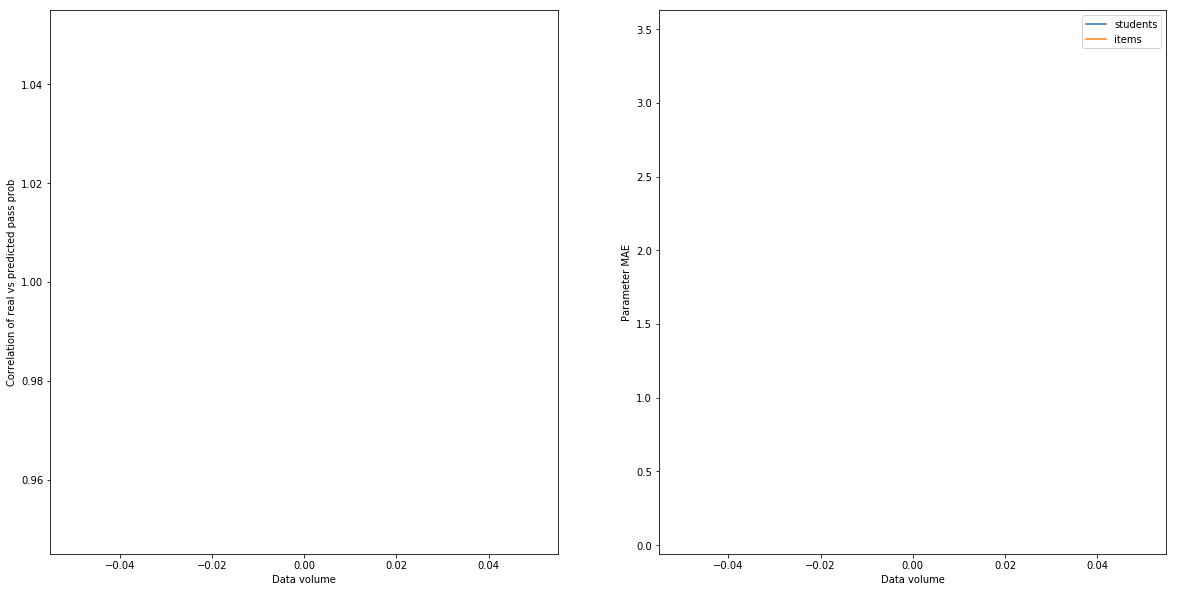

In [18]:
xs = [tup[0] for tup in volume_to_r]
xss = [x**2 for x in xs]
rs = [tup[1] for tup in volume_to_r]
serrs = [tup[1] for tup in maes]
qerrs = [tup[2] for tup in maes]
print(xs)
print(xss)
print(rs)
print(serrs)
print(qerrs)

rdf = pandas.DataFrame(index=range(len(xs)), columns=["x","x2","r","serr","qerr"])
# rdf = None
# rdf = pandas.read_csv("rdf.csv", index_col=0)
print(rdf)

ix=0
for x,x2,r,serr,qerr in zip(xs,xss,rs,serrs,qerrs):
    print([x, x2,r,serr,qerr])
    rdf.loc[ix] = [x,x2,r,serr,qerr]
    ix += 1
#     rdf.loc[x,:]=[x2,r,serr,qerr]
rdf = rdf.sort_values(["x2"])
    
# rdf = rdf.drop(rdf.index[-1])
# rdf["xs2"] = xss
# rdf["rs"] = rs
# rdf["serrs"] = serrs
# rdf["qerrs"] = qerrs
rdf.to_csv("rdf.csv")
print(rdf)


fig, axs = plt.subplots(1,2)
fig.set_size_inches(20,10)
axs[0].plot(rdf.x2, rdf.r)
axs[0].set_ylabel("Correlation of real vs predicted pass prob")
axs[0].set_xlabel("Data volume")
axs[1].plot(rdf.x2, rdf.serr, label="students")
axs[1].plot(rdf.x2, rdf.qerr, label="items")
axs[1].set_ylabel("Parameter MAE")
axs[1].set_xlabel("Data volume")
axs[1].legend()
plt.show()


In [19]:
    MaxL = -min_loss
    print(-min_loss*len(qs)*len(ss))
    nparams = len(qs)*nnw + len(ss)*nnw
    print(nparams)
    BIC = log(len(qs)*len(ss))*(nparams)-2*log(exp(MaxL))
#     {\displaystyle \mathrm {BIC} ={\ln(n)k-2\ln({\hat {L}})}.\ }
    #qs_model.load_weights("qs_best_weights_summative.hdf5")
    
print(MaxL, BIC)
gc.collect()

-311.863662958


NameError: name 'nnw' is not defined

In [ ]:
clear_output()
print("elements in h:", len(h))
for tup in h:
    print(tup)

loss, mse, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].plot(acc, label="acc")
axes[1].plot(loss, label="loss")
axes[2].plot(mse, label="mse")

fig.set_size_inches(20, 5)
for i in [0,1,2]:
    axes[i].legend()
plt.show()

# av_fit_rmses = []
# for b,th in zip(b_fit_rmses, th_fit_rmses):
#     av = (b+th)/2.0
#     av_fit_rmses.append(av)
    
# plt.plot(b_fit_rmses, label="d fit")
# plt.plot(th_fit_rmses, label="a fit")
# plt.plot(av_fit_rmses, label="avg")
# plt.legend()
# plt.show()


In [ ]:
s_wgtz = array([ s.thetas for s in ss ])
shat_wgtz = s_table.get_weights()[0]
shat, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(s_wgtz, shat_wgtz, max_iter=10)

# for real,out in zip(s_wgtz, shat):
#     print(real," -- ",out)
# print(pred_wgts)
# print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

real_wgtz = array([ q.betas for q in qs ])
pred_wgtz = q_table.get_weights()[0]
chosen, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

# for real,out in zip(real_wgtz, chosen):
#     print(real," -- ",out)
# print(pred_wgts)
# print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

In [ ]:
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean
real_wgtz = array([ q.betas for q in qs ])
w = real_wgtz.shape[1]
print("dims",w)
zero_vec = numpy.ones(w)

mag = lambda arr: numpy.sqrt(numpy.sum(arr**2))

euc_sums=[]
nearests=[]
for ix, (rw, ch) in enumerate(zip(real_wgtz, chosen)):
    print(">>>")
    print(cosine(rw, zero_vec))
    print(cosine(ch, zero_vec))
    print(cosine(rw,ch))
#     print("pearson corr", pearsonr(rw,ch))
    nearest_eucl = euclidean(rw,ch) 
    print("eucl.",nearest_eucl)
    nearests.append(nearest_eucl)
    print("mag ",mag(rw))
    print("mag^",mag(ch))
#     print("dmag", mag(rw)-mag(ch))
    euc_sum=0
    for ix2, rww in enumerate(real_wgtz):
        if ix!=ix2:
            euc_sum+=euclidean(rww,ch)
    euc_sum /= len(real_wgtz-1)
    euc_sums.append(euc_sum)
    print("avg euc to others:", euc_sum)

In [ ]:
from scipy.stats import ttest_ind

print("\nsummary")
print(len(nearests), len(euc_sums))
print("mean dist(V,V^):", numpy.mean(nearests), "std:", numpy.std(nearests))
print("mean dist to other points:", numpy.mean(euc_sums), "std:", numpy.std(euc_sums))

tt = ttest_ind(nearests,euc_sums, equal_var=False)
print(tt)

# ratios = array(euc_sums)/array(nearests)
# print("min/max ratios of avg/(V,V^) dist:", numpy.min(ratios), numpy.max(ratios))
# print("mean,med,std of ratios:", numpy.mean(ratios), numpy.median(ratios), numpy.std(ratios))

from scipy.stats import pearsonr
print("pearson's corr/n:", pearsonr(real_wgtz.flatten(), chosen.flatten()))


In [ ]:
for h,w in zip(histoires, nn_dimensions):
    x = range(len(h))
    loss = [tup[0] for tup in h]
    acc = [tup[2] for tup in h]
#     plt.plot(x,loss, label=w)
    plt.plot(x,acc, label=w)
plt.gcf().set_size_inches(10, 10)
plt.legend()
plt.show()


In [ ]:

rows=[]
#df = pandas.DataFrame(index=range(N), columns=["s_id","q_id","run0","rerun","mined","p0","p_mined"])
ix=0
for tup in x:
    (psi_id, q_id, passed, passed) = tup
    p = calculate_pass_probability(ss[psi_id].thetas, qs[q_id].betas)
    summa += log((p if passed else (1-p)), base)

    pp = uniform(0,1)
    if pp <= p:
        ppassed=1
        if passed:
            tp+=1
        else:
            fp+=1
    else:
        ppassed=0
        if passed:
            fn+=1
        else:
            tn+=1
            
    row = [psi_id, q_id, passed, ppassed, None, p, None, None, None, None]
    rows.append(row)
#     print(ix)
    ix += 1

acc = (tp+tn)/len(x)
print(n_traits, nn_dimensions, min_active_traits, max_active_traits)
print("model acc:",acc)
print(tp,fp)
print(fn,tn)

ppx = pow( base, (-summa/N))
print("perplexity is {}".format(ppx))
print((fn + fp + abs(tp-tn)),":", tp,tn,fp,fn)

In [ ]:
sws = s_table.get_weights()[0]
pred_wgtz = q_table.get_weights()[0]

base = 2
ix=0

LR_rows = []



df = results_sheet(qs,ss, sws, pred_wgtz)

In [ ]:
from sklearn.metrics import cohen_kappa_score
kappa_self = cohen_kappa_score(df["run0"], df["rerun"])
kappa_embg = cohen_kappa_score(df["run0"], df["mined"])
print(kappa_self, kappa_embg)

agrt_self = sum(df["run0"]==df["rerun"])/len(df)
agrt_embg = sum(df["run0"]==df["mined"])/len(df)
# print(agrt_self, agrt_embg)

N = len(df)

In [ ]:
# print("spearman's corr/n:", spearmanr(df["run0"], df["mined"]))

# n01 = numpy.sum(df["run0"]==0)
# n11 = numpy.sum(df["run0"]==1)
# n02 = numpy.sum(df["mined"]==0)
# n12 = numpy.sum(df["mined"]==1)

# props = {}

# pe = ((n01*n02) + (n11*n12))/(N**2)
# sum_ii = 

In [ ]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# pca = PCA(n_components=2)
pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])
# ixes = itemz < baseline
# itemz[ixes] = (baseline-1)
# itemz = itemz - (baseline-1)

itemz_pred = chosen
n = len(chosen)
rot = array([[-1,0],[0,-1]])

print(itemz.shape, itemz_pred.shape)


# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
itemz_2 = pca.fit_transform(itemz_2)

# for nx in range(n):
#     itemz_2[n+nx] = rot @ itemz_2[n+nx]


# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

plt.xlabel("Component 1")
plt.ylabel("Component 2")
fig.show()

In [ ]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# pca = PCA(n_components=2)
pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ s.thetas for s in ss ])
# ixes = itemz < baseline
# itemz[ixes] = (baseline-1)
# itemz = itemz - (baseline-1)

itemz_pred = shat
n = len(shat)
rot = array([[-1,0],[0,-1]])

print(itemz.shape, itemz_pred.shape)


# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
itemz_2 = pca.fit_transform(itemz_2)

# for nx in range(n):
#     itemz_2[n+nx] = rot @ itemz_2[n+nx]


# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

plt.xlabel("Component 1")
plt.ylabel("Component 2")
fig.show()